# Setup

In [ ]:
#for colab
#from google.colab import drive
#drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D,  MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adagrad, Adadelta, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
import warnings
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')


2024-05-17 16:18:03.122278: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 16:18:04.887276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 16:18:09.534954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Predefining Stuff - all you have to change is the path
data_dir = '/mnt/c/Users/tomgo/Documents/NOVA/S2/Machine_Learning/Group_Project/Project_part_2/Alzheimers_Dataset'
img_height = 208
img_width = 176
batch_size = 16
seed = 33

class_names = {
    'Non Demented' : 2,
    'Very Mild Demented' : 3,
    'Mild Demented' : 0,
    'Moderate Demented' : 1
}

In [3]:


# Function to preprocess and normalize images
def preprocess(image, label):
    return layers.Rescaling(1./255)(image), label


# Load and preprocess the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + '/train',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(preprocess)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + '/test',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(preprocess)

# Concatenate train and test datasets to shuffle and split later
all_images_ds = train_ds.concatenate(test_ds)

# Shuffle the dataset thoroughly
all_images_ds = all_images_ds.shuffle(buffer_size=10000, reshuffle_each_iteration= False, seed=seed)

# Set AUTOTUNE to optimize loading performance
AUTOTUNE = tf.data.AUTOTUNE
all_ds = all_images_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Calculate the total number of batches
total_batches = tf.data.experimental.cardinality(all_ds).numpy()

# Calculate sizes for train, validation, and test sets
train_size = int(total_batches * 0.6)
val_size = int(total_batches * 0.2)
test_size = total_batches - train_size - val_size

# Split the dataset into train, validation, and test datasets
train_ds = all_ds.take(train_size)
val_ds = all_ds.skip(train_size).take(val_size)
test_ds = all_ds.skip(train_size + val_size)

total_images = 0
for images, labels in test_ds:
    total_images += images.shape[0]  # Add the batch size to total

print("Total number of instances in the dataset:", total_images)

total_images = 0
for images, labels in test_ds:
    total_images += images.shape[0]  # Add the batch size to total

print("Total number of instances in the dataset:", total_images)


# Output shapes and class distribution
print("Number of train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Number of validation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Number of test batches:", tf.data.experimental.cardinality(test_ds).numpy())

# Unbatch the dataset and calculate class counts and weights (for training set)
class_counts = {}
for image, label in train_ds.unbatch():  # Assuming each element is a single image-label pair
    label = label.numpy()  # Convert the label to numpy (scalar)
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

print("Class counts in train set:", class_counts)

# Compute class weights based on training set
classes = list(class_counts.keys())
counts = list(class_counts.values())
weights = compute_class_weight(class_weight='balanced', classes=np.array(classes), y=np.concatenate([[cls]*count for cls, count in zip(classes, counts)]))
class_weights = {cls: weight for cls, weight in zip(classes, weights)}

print("Class weights:", class_weights)


Found 5121 files belonging to 4 classes.


2024-05-17 16:19:21.778741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 16:19:21.789437: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 1279 files belonging to 4 classes.


2024-05-17 16:19:39.824259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 144 of 10000
2024-05-17 16:19:52.787283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 183 of 10000
2024-05-17 16:20:09.719867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-17 16:20:09.751717: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 7028800 bytes after encountering the first element of size 7028800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-05-17 16:20:10.086628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total number of instances in the dataset: 1296
Total number of instances in the dataset: 1296
Number of train batches: 240
Number of validation batches: 80
Number of test batches: 81


2024-05-17 16:20:10.570349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-17 16:20:19.753196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class counts in train set: {2: 1932, 3: 1344, 0: 520, 1: 44}
Class weights: {2: 0.4968944099378882, 3: 0.7142857142857143, 0: 1.8461538461538463, 1: 21.818181818181817}


In [4]:
sets = [all_ds, train_ds, val_ds, test_ds]
names = ['all','train', 'validation', 'test']

# Dictionary to store counts
counts = {
    'Non Demented' : [],
    'Very Mild Demented' : [],
    'Mild Demented' : [],
    'Moderat Demented' : []
}

# Function to count classes in a dataset
def count_classes(dataset):
    # Local dictionary to hold counts for the current dataset
    temp_counts = {
        'Non Demented': 0,
        'Very Mild Demented': 0,
        'Mild Demented': 0,
        'Moderat Demented': 0
    }

    for images, labels in dataset:
        for label in labels.numpy():
            if label == 0:
                temp_counts['Mild Demented'] += 1
            elif label == 1:
                temp_counts['Moderat Demented'] += 1
            elif label == 2:
                temp_counts['Non Demented'] += 1
            elif label == 3:
                temp_counts['Very Mild Demented'] += 1

    return temp_counts

# Iterating over each set and storing counts separately
for i, dataset in enumerate(sets):
    dataset_counts = count_classes(dataset)
    print(f"Counts for {names[i]} set:")
    for key in counts:
        counts[key].append(dataset_counts[key])
        print(f"  {key}: {dataset_counts[key]}")


2024-05-17 16:20:23.469229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Counts for all set:
  Non Demented: 3200
  Very Mild Demented: 2240
  Mild Demented: 896
  Moderat Demented: 64
Counts for train set:
  Non Demented: 1932
  Very Mild Demented: 1344
  Mild Demented: 520
  Moderat Demented: 44
Counts for validation set:
  Non Demented: 608
  Very Mild Demented: 453
  Mild Demented: 192
  Moderat Demented: 11
Counts for test set:
  Non Demented: 660
  Very Mild Demented: 443
  Mild Demented: 184
  Moderat Demented: 9


2024-05-17 16:20:23.776678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-17 16:20:23.886656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-17 16:20:23.946284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:

def evaluateModel(val_ds, model, history ):
    val_labels = []
    val_scores = []  # Use this to store raw probabilities

    # Iterate through the entire dataset
    for images, labels in val_ds:
        scores = model.predict(images, verbose=0)
        val_scores.extend(scores)
        val_labels.extend(labels.numpy())

    # Convert to NumPy arrays
    val_labels = np.array(val_labels)
    val_scores = np.array(val_scores)
    val_preds = np.argmax(val_scores, axis=1)  # Use argmax to find highest probability class

    # Ensure labels are in categorical format for ROC curve calculation
    if len(val_labels.shape) == 1:  # Check if labels are not one-hot encoded
        val_labels = to_categorical(val_labels, num_classes=val_scores.shape[1])

    # Define class labels and names from dictionary
    class_labels = list(class_names.values())  # [2, 3, 0, 1]
    label_names = list(class_names.keys())  # Corresponding class names

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(val_labels, axis=1), val_preds, labels=class_labels)
    print("Classification Report:")
    print(classification_report(np.argmax(val_labels, axis=1), val_preds, target_names=label_names))


    # Plot training and validation accuracy values
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plotting the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix as Heatmap')
    plt.show()


# Baseline Model

In [ ]:
# Define the model architecture
model = Sequential([
    Flatten(input_shape=(208, 176, 3)),  # Assuming images are 208x176 with 3 channels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # Assuming 4 classes in the output
])

# Compile the model with SGD optimizer
model.compile(
    optimizer=SGD(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Adjust the number of epochs as needed
    verbose=1,  # Ensures that loss and accuracy are printed after each epoch
    class_weight = class_weights
)


Epoch 1/20
240/240 [==============================] - 3s 8ms/step - loss: 1.4828 - accuracy: 0.1008 - val_loss: 1.3931 - val_accuracy: 0.1519
Epoch 2/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3877 - accuracy: 0.1086 - val_loss: 1.3888 - val_accuracy: 0.1519
Epoch 3/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3876 - accuracy: 0.1365 - val_loss: 1.3881 - val_accuracy: 0.1519
Epoch 4/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3876 - accuracy: 0.1435 - val_loss: 1.3877 - val_accuracy: 0.1519
Epoch 5/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3876 - accuracy: 0.1477 - val_loss: 1.3875 - val_accuracy: 0.1519
Epoch 6/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3876 - accuracy: 0.1521 - val_loss: 1.3874 - val_accuracy: 0.1519
Epoch 7/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3876 - accuracy: 0.1526 - val_loss: 1.3873 - val_accuracy: 0.1519
Epoch 

# Evaluation Baseline

Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.00      0.00      0.00       192
Very Mild Demented       0.00      0.00      0.00        11
     Mild Demented       0.48      1.00      0.65       608
 Moderate Demented       0.00      0.00      0.00       453

          accuracy                           0.48      1264
         macro avg       0.12      0.25      0.16      1264
      weighted avg       0.23      0.48      0.31      1264



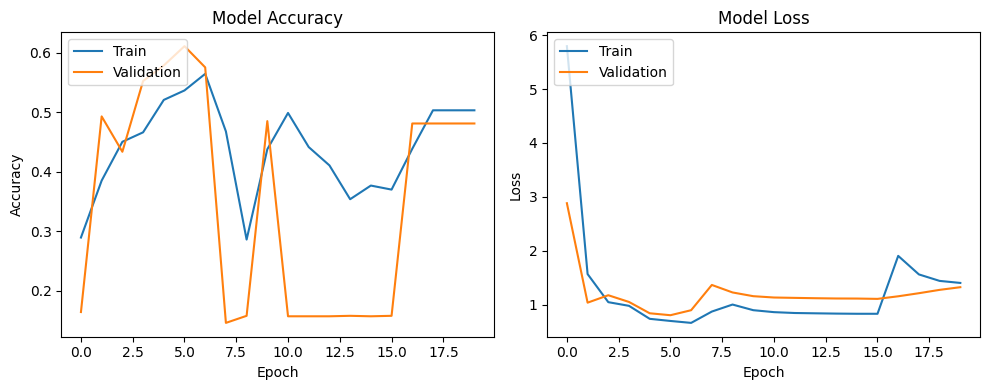

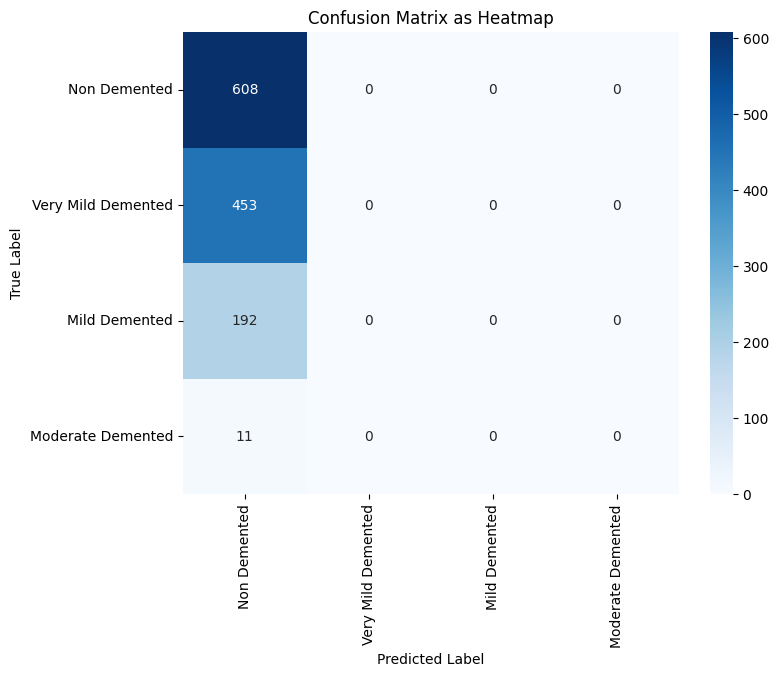

In [ ]:
evaluateModel(model = model, val_ds = val_ds, history = history)

#### Save model

In [ ]:

#model.save('/mnt/c/Users/tomgo/Documents/NOVA/S2/Machine_Learning/Group_Project/Project_part_2/Baseline_2.keras')

# Improved Baseline Model

*   Different optimizers (SGD, Adagrad, Adadelta, Adam)
*   Batch Normalization
*   Early Stopping
*   Dropouts
*   Regularization
*   Weight regularization







Training with SGD optimizer.
Epoch 1/20
240/240 [==============================] - 3s 8ms/step - loss: 1.4771 - accuracy: 0.1023 - val_loss: 1.3894 - val_accuracy: 0.0087
Epoch 2/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3876 - accuracy: 0.1240 - val_loss: 1.3884 - val_accuracy: 0.1519
Epoch 3/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3876 - accuracy: 0.1388 - val_loss: 1.3879 - val_accuracy: 0.1519
Epoch 4/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3876 - accuracy: 0.1464 - val_loss: 1.3876 - val_accuracy: 0.1519
Epoch 5/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3876 - accuracy: 0.1474 - val_loss: 1.3874 - val_accuracy: 0.1519
Epoch 6/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3876 - accuracy: 0.1516 - val_loss: 1.3874 - val_accuracy: 0.1519
Epoch 7/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3876 - accuracy: 0.1521 - val_loss: 1.3873 

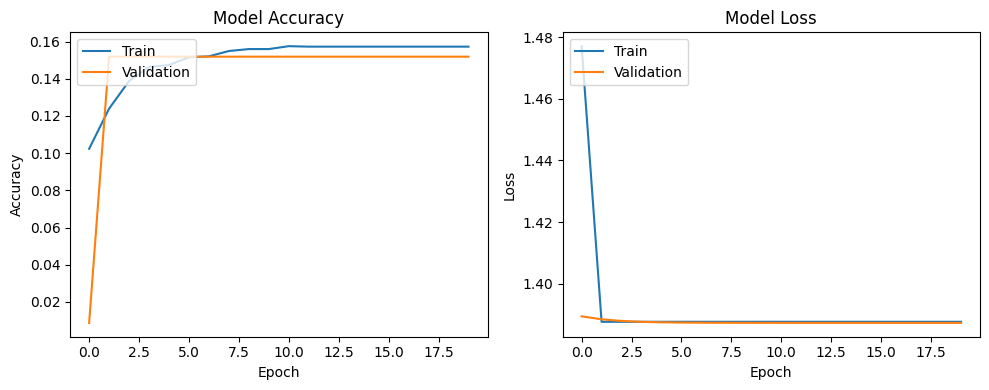

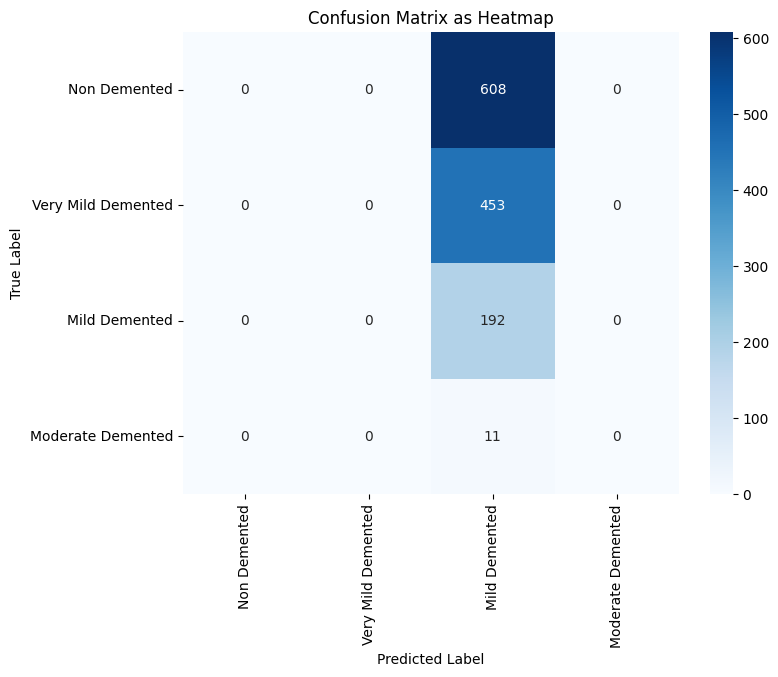

Training with Adagrad optimizer.
Epoch 1/20
240/240 [==============================] - 3s 8ms/step - loss: 1.4889 - accuracy: 0.2812 - val_loss: 1.4840 - val_accuracy: 0.1772
Epoch 2/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3559 - accuracy: 0.4284 - val_loss: 1.3254 - val_accuracy: 0.4328
Epoch 3/20
240/240 [==============================] - 2s 7ms/step - loss: 1.3071 - accuracy: 0.4297 - val_loss: 1.2804 - val_accuracy: 0.4233
Epoch 4/20
240/240 [==============================] - 2s 7ms/step - loss: 1.2311 - accuracy: 0.4750 - val_loss: 1.2319 - val_accuracy: 0.4715
Epoch 5/20
240/240 [==============================] - 2s 7ms/step - loss: 1.1559 - accuracy: 0.5047 - val_loss: 1.1740 - val_accuracy: 0.5356
Epoch 6/20
240/240 [==============================] - 2s 7ms/step - loss: 1.0838 - accuracy: 0.5398 - val_loss: 1.1291 - val_accuracy: 0.5427
Epoch 7/20
240/240 [==============================] - 2s 7ms/step - loss: 1.0187 - accuracy: 0.5562 - val_loss: 1.0

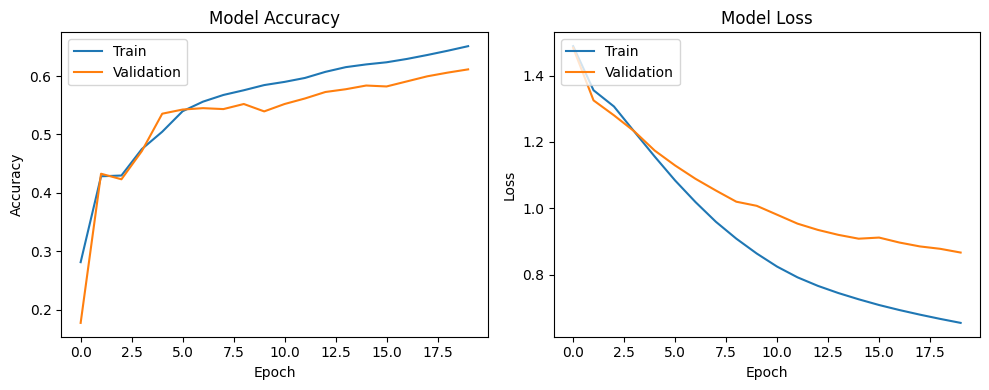

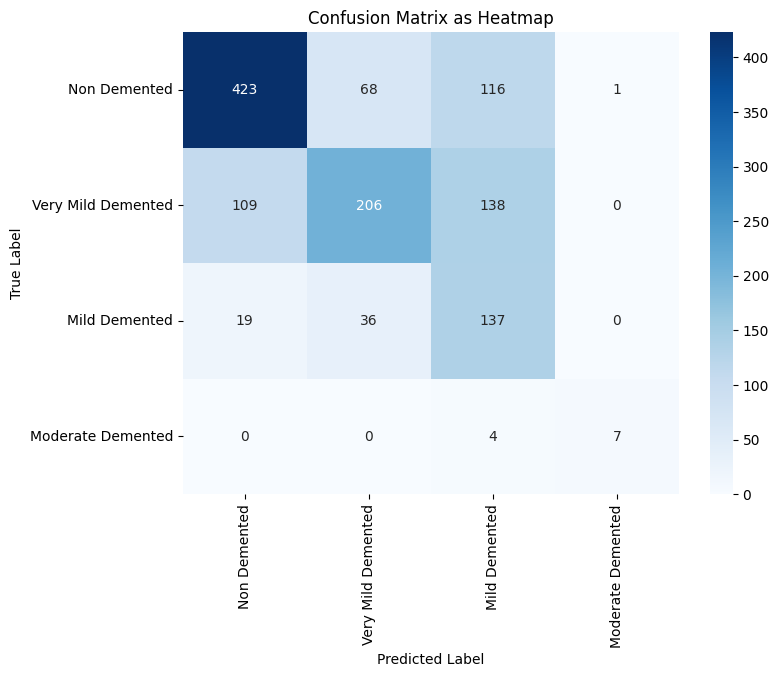

Training with Adadelta optimizer.
Epoch 1/20
240/240 [==============================] - 3s 9ms/step - loss: 1.3947 - accuracy: 0.4193 - val_loss: 1.2883 - val_accuracy: 0.4225
Epoch 2/20
240/240 [==============================] - 2s 8ms/step - loss: 1.3235 - accuracy: 0.4690 - val_loss: 1.2592 - val_accuracy: 0.4502
Epoch 3/20
240/240 [==============================] - 2s 8ms/step - loss: 1.2837 - accuracy: 0.4896 - val_loss: 1.2310 - val_accuracy: 0.4636
Epoch 4/20
240/240 [==============================] - 2s 8ms/step - loss: 1.2459 - accuracy: 0.4867 - val_loss: 1.2088 - val_accuracy: 0.4612
Epoch 5/20
240/240 [==============================] - 2s 8ms/step - loss: 1.2082 - accuracy: 0.4932 - val_loss: 1.1900 - val_accuracy: 0.4723
Epoch 6/20
240/240 [==============================] - 2s 8ms/step - loss: 1.1759 - accuracy: 0.5023 - val_loss: 1.1728 - val_accuracy: 0.4707
Epoch 7/20
240/240 [==============================] - 2s 8ms/step - loss: 1.1455 - accuracy: 0.5104 - val_loss: 1.

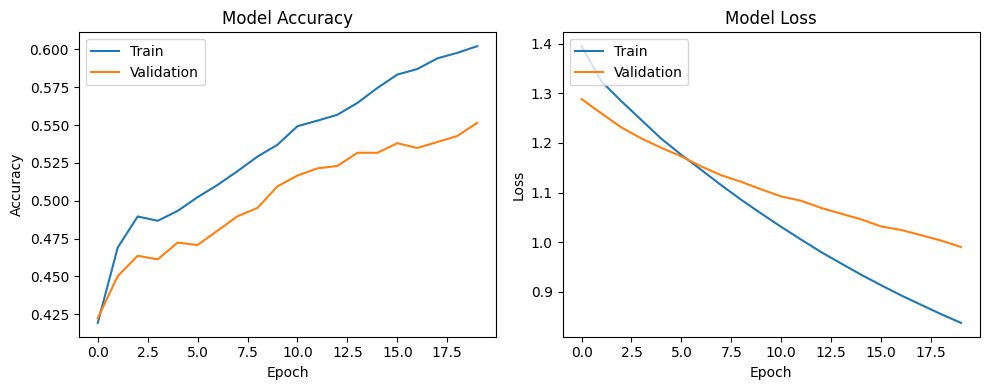

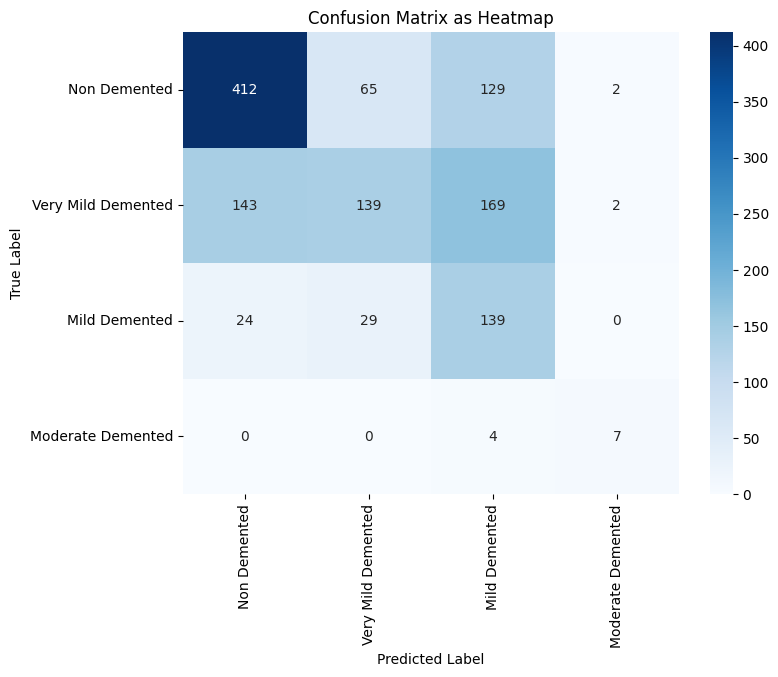

Training with Adam optimizer.
Epoch 1/20
240/240 [==============================] - 3s 9ms/step - loss: 7.3532 - accuracy: 0.2760 - val_loss: 1.6210 - val_accuracy: 0.5522
Epoch 2/20
240/240 [==============================] - 2s 8ms/step - loss: 1.6181 - accuracy: 0.3836 - val_loss: 1.1633 - val_accuracy: 0.4430
Epoch 3/20
240/240 [==============================] - 2s 8ms/step - loss: 1.1260 - accuracy: 0.4310 - val_loss: 0.9411 - val_accuracy: 0.5301
Epoch 4/20
240/240 [==============================] - 2s 8ms/step - loss: 0.7561 - accuracy: 0.5221 - val_loss: 0.9141 - val_accuracy: 0.5918
Epoch 5/20
240/240 [==============================] - 2s 8ms/step - loss: 0.6822 - accuracy: 0.5747 - val_loss: 0.7776 - val_accuracy: 0.6337
Epoch 6/20
240/240 [==============================] - 2s 8ms/step - loss: 0.6292 - accuracy: 0.6062 - val_loss: 0.7743 - val_accuracy: 0.6440
Epoch 7/20
240/240 [==============================] - 2s 8ms/step - loss: 0.5819 - accuracy: 0.6375 - val_loss: 0.7012

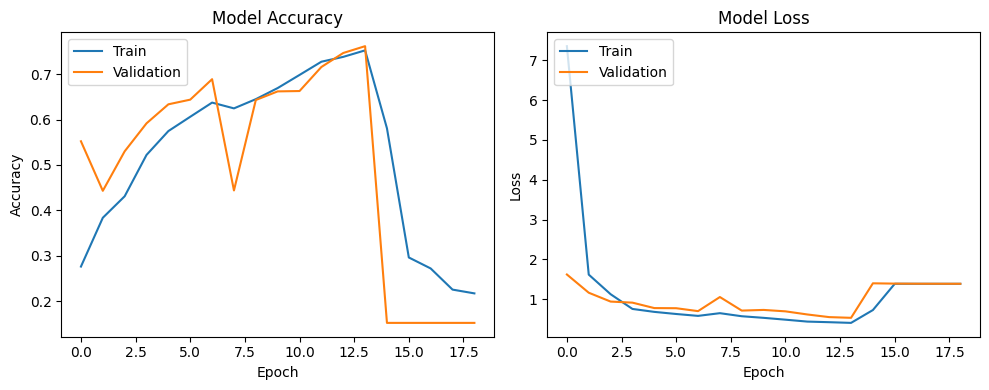

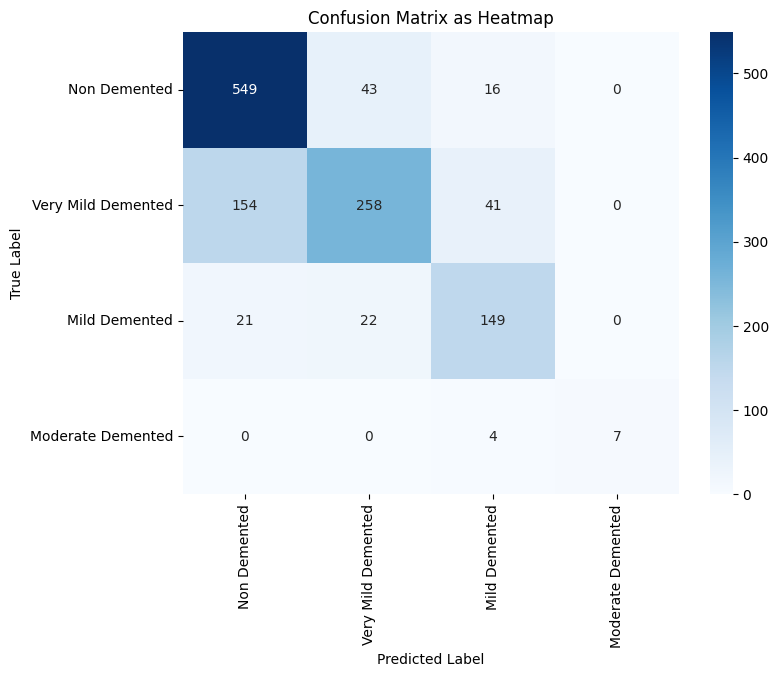

In [ ]:
#Different optimizers (SGD, Adagrad, Adadelta, Adam) + Early stopping

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# List of different optimizers to try
optimizers = {
    'SGD': SGD(),
    'Adagrad': Adagrad(),
    'Adadelta': Adadelta(),
    'Adam': Adam()
}

# Example of setting up the model with different optimizers
for name, optimizer in optimizers.items():
    # Define the model architecture within the loop
    model = Sequential([
        Flatten(input_shape=(208, 176, 3)),  # Assuming images are 208x176 with 3 channels
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')  # Assuming 4 classes in the output
    ])

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"Training with {name} optimizer.")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,  # Adjust the number of epochs as needed
        verbose=1,  # Ensures that loss and accuracy are printed after each epoch
        class_weight=class_weights,
        callbacks=[early_stopping]  # Add the early stopping callback here
    )

    evaluateModel(model=model, val_ds=val_ds, history=history)

We will continue with using Adam because if has the best metric scores for the shortest run time.

Epoch 1/20
240/240 [==============================] - 5s 11ms/step - loss: 1.0438 - accuracy: 0.4612 - val_loss: 0.9248 - val_accuracy: 0.6226
Epoch 2/20
240/240 [==============================] - 2s 10ms/step - loss: 0.4192 - accuracy: 0.7747 - val_loss: 0.5541 - val_accuracy: 0.8062
Epoch 3/20
240/240 [==============================] - 2s 10ms/step - loss: 0.1635 - accuracy: 0.9323 - val_loss: 0.3569 - val_accuracy: 0.8884
Epoch 4/20
240/240 [==============================] - 2s 10ms/step - loss: 0.0645 - accuracy: 0.9826 - val_loss: 0.3538 - val_accuracy: 0.8884
Epoch 5/20
240/240 [==============================] - 2s 10ms/step - loss: 0.0362 - accuracy: 0.9919 - val_loss: 0.5677 - val_accuracy: 0.8441
Epoch 6/20
240/240 [==============================] - 2s 10ms/step - loss: 0.0306 - accuracy: 0.9898 - val_loss: 0.3052 - val_accuracy: 0.8932
Epoch 7/20
240/240 [==============================] - 2s 10ms/step - loss: 0.0922 - accuracy: 0.9578 - val_loss: 0.7537 - val_accuracy: 0.7745

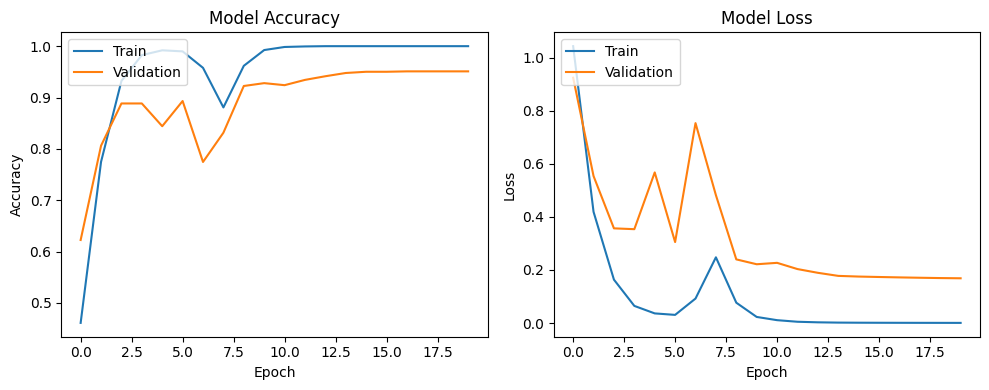

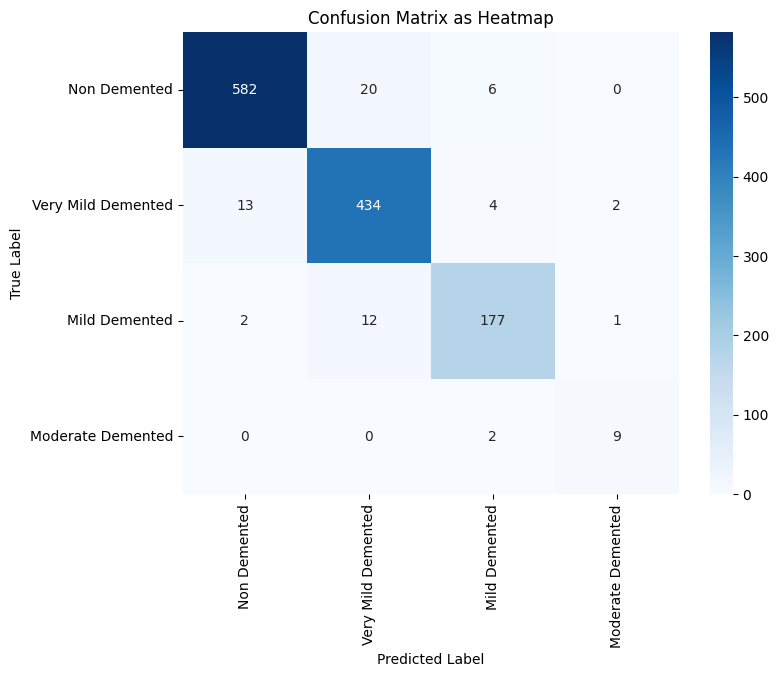

In [ ]:
# Define the model architecture
model = Sequential([
    Flatten(input_shape=(208, 176, 3)),  # Assuming images are 208x176 with 3 channels
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')  # Assuming 4 classes in the output
])

# Compile the model with Adadelta optimizer
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

evaluateModel(model=model, val_ds=val_ds, history=history)

We will continue using batch normalization, because it improves the results.

Epoch 1/20
240/240 [==============================] - 5s 11ms/step - loss: 1.6548 - accuracy: 0.3289 - val_loss: 1.1814 - val_accuracy: 0.4557
Epoch 2/20
240/240 [==============================] - 2s 10ms/step - loss: 1.3284 - accuracy: 0.3781 - val_loss: 1.1031 - val_accuracy: 0.4826
Epoch 3/20
240/240 [==============================] - 2s 10ms/step - loss: 1.1475 - accuracy: 0.4130 - val_loss: 0.9892 - val_accuracy: 0.5324
Epoch 4/20
240/240 [==============================] - 2s 10ms/step - loss: 1.0080 - accuracy: 0.4424 - val_loss: 0.9096 - val_accuracy: 0.5878
Epoch 5/20
240/240 [==============================] - 2s 10ms/step - loss: 0.9139 - accuracy: 0.4927 - val_loss: 0.8939 - val_accuracy: 0.5878
Epoch 6/20
240/240 [==============================] - 2s 10ms/step - loss: 0.8391 - accuracy: 0.5117 - val_loss: 0.8909 - val_accuracy: 0.5744
Epoch 7/20
240/240 [==============================] - 2s 10ms/step - loss: 0.7791 - accuracy: 0.5266 - val_loss: 0.8448 - val_accuracy: 0.5902

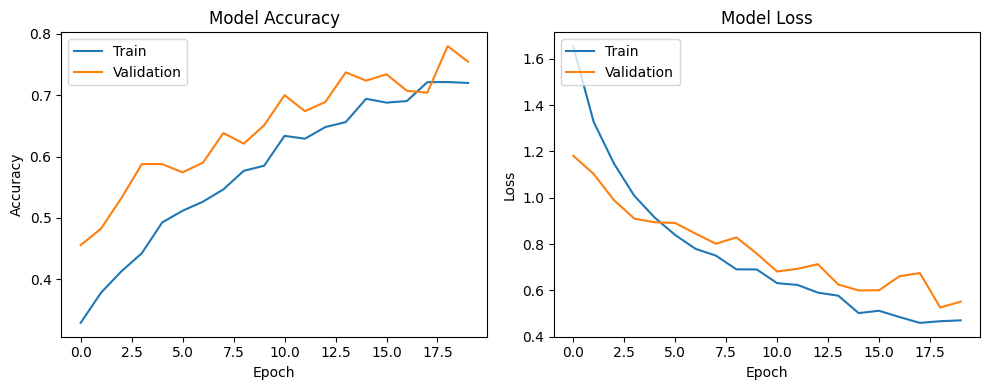

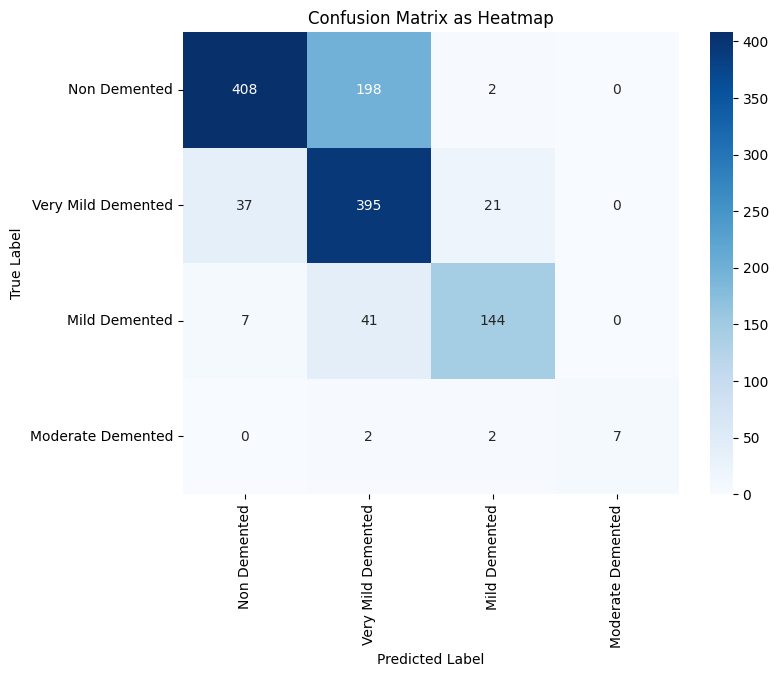

In [ ]:
# Define the model architecture
model = Sequential([
    Flatten(input_shape=(208, 176, 3)),  # Assuming images are 208x176 with 3 channels
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Adding dropout with a rate of 0.5
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Adding dropout with a rate of 0.5
    BatchNormalization(),
    Dense(4, activation='softmax')  # Assuming 4 classes in the output
])

# Compile the model with Adadelta optimizer
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

evaluateModel(model=model, val_ds=val_ds, history=history)

We will not include dropouts because they worsen the performance


Epoch 1/20
240/240 [==============================] - 5s 12ms/step - loss: 1.5280 - accuracy: 0.4805 - val_loss: 1.3838 - val_accuracy: 0.6472
Epoch 2/20
240/240 [==============================] - 3s 11ms/step - loss: 0.8776 - accuracy: 0.7792 - val_loss: 0.9842 - val_accuracy: 0.8062
Epoch 3/20
240/240 [==============================] - 3s 11ms/step - loss: 0.6742 - accuracy: 0.8818 - val_loss: 1.0364 - val_accuracy: 0.7998
Epoch 4/20
240/240 [==============================] - 3s 11ms/step - loss: 0.7774 - accuracy: 0.8677 - val_loss: 1.1669 - val_accuracy: 0.7848
Epoch 5/20
240/240 [==============================] - 3s 11ms/step - loss: 1.2695 - accuracy: 0.8279 - val_loss: 1.5013 - val_accuracy: 0.7611
Epoch 6/20
240/240 [==============================] - 3s 11ms/step - loss: 0.8867 - accuracy: 0.8992 - val_loss: 1.0929 - val_accuracy: 0.8204
Epoch 7/20
240/240 [==============================] - 3s 11ms/step - loss: 0.8552 - accuracy: 0.8768 - val_loss: 1.3580 - val_accuracy: 0.7769

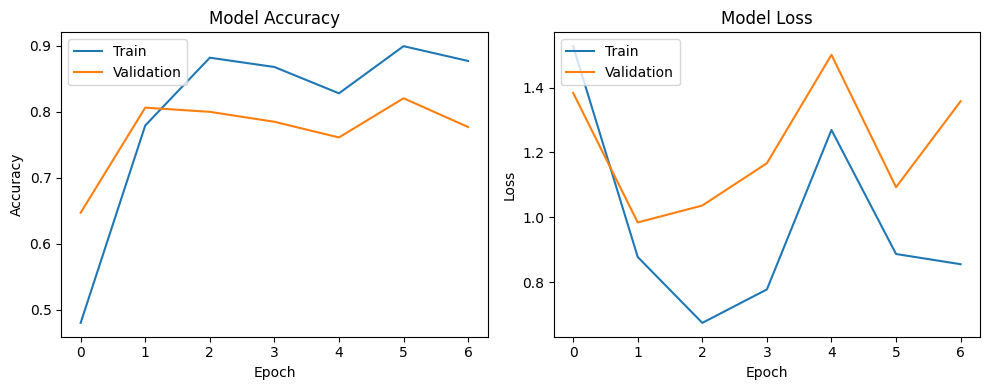

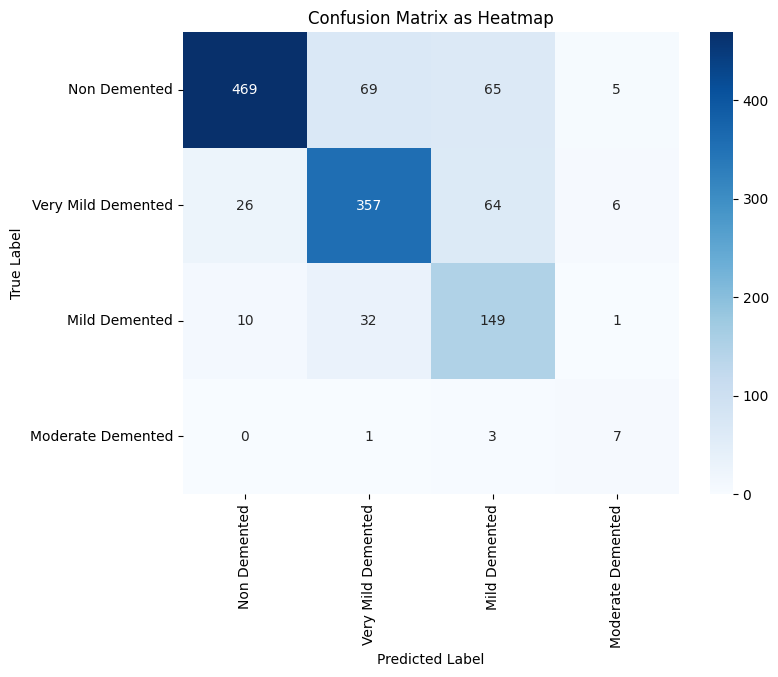

In [ ]:
# Define the model architecture with L2 regularization
model = Sequential([
    Flatten(input_shape=(208, 176, 3)),  # Assuming images are 208x176 with 3 channels
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dense(4, activation='softmax')  # Assuming 4 classes in the output
])

# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

evaluateModel(model=model, val_ds=val_ds, history=history)

We will not use Regularization because it worsens the performance.

Epoch 1/20
240/240 [==============================] - 28s 105ms/step - loss: 0.9637 - accuracy: 0.5271 - val_loss: 11.1609 - val_accuracy: 0.3695
Epoch 2/20
240/240 [==============================] - 25s 104ms/step - loss: 0.2138 - accuracy: 0.9018 - val_loss: 6.2712 - val_accuracy: 0.4019
Epoch 3/20
240/240 [==============================] - 25s 105ms/step - loss: 0.0460 - accuracy: 0.9883 - val_loss: 5.2318 - val_accuracy: 0.4937
Epoch 4/20
240/240 [==============================] - 25s 105ms/step - loss: 0.0183 - accuracy: 0.9971 - val_loss: 1.3041 - val_accuracy: 0.5997
Epoch 5/20
240/240 [==============================] - 25s 104ms/step - loss: 0.0109 - accuracy: 0.9987 - val_loss: 0.9803 - val_accuracy: 0.6725
Epoch 6/20
240/240 [==============================] - 25s 105ms/step - loss: 0.0061 - accuracy: 0.9992 - val_loss: 0.1258 - val_accuracy: 0.9620
Epoch 7/20
240/240 [==============================] - 25s 104ms/step - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.2498 - val_a

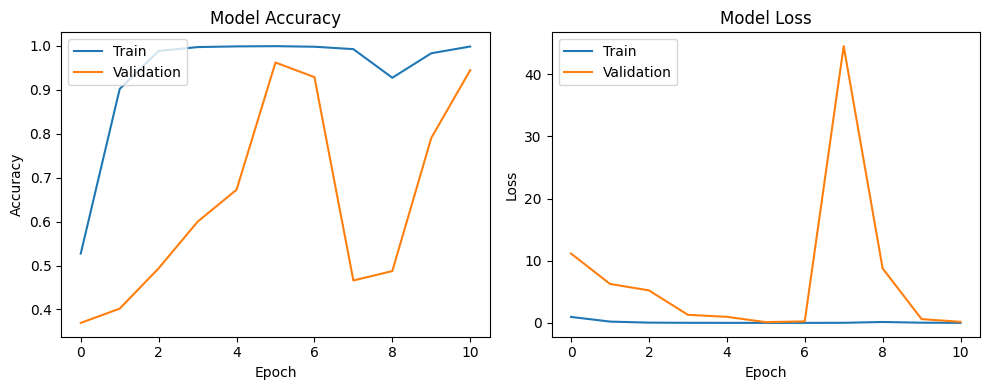

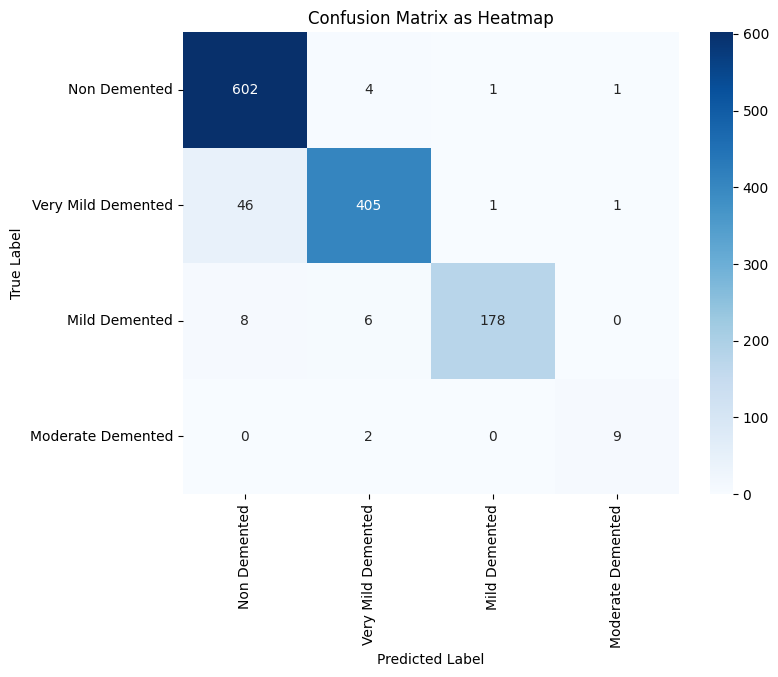

Performance on Test data (previously unseen)
Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.98      0.93      0.96       184
Very Mild Demented       1.00      1.00      1.00         9
     Mild Demented       0.91      0.99      0.95       660
 Moderate Demented       0.98      0.87      0.92       443

          accuracy                           0.94      1296
         macro avg       0.97      0.95      0.96      1296
      weighted avg       0.95      0.94      0.94      1296



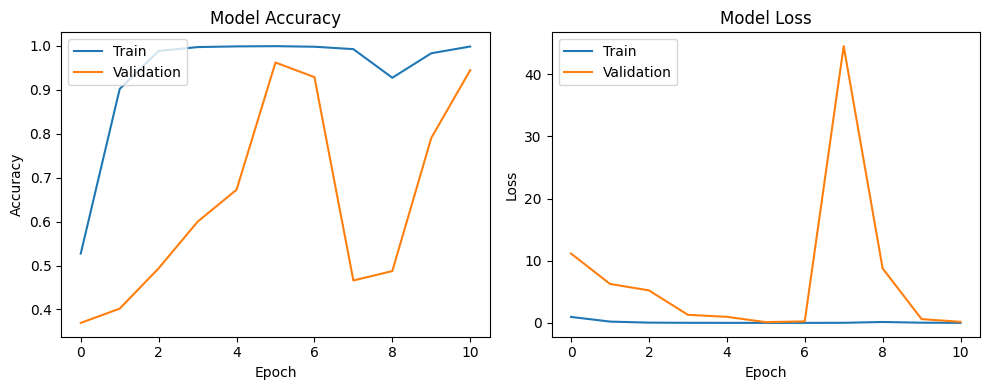

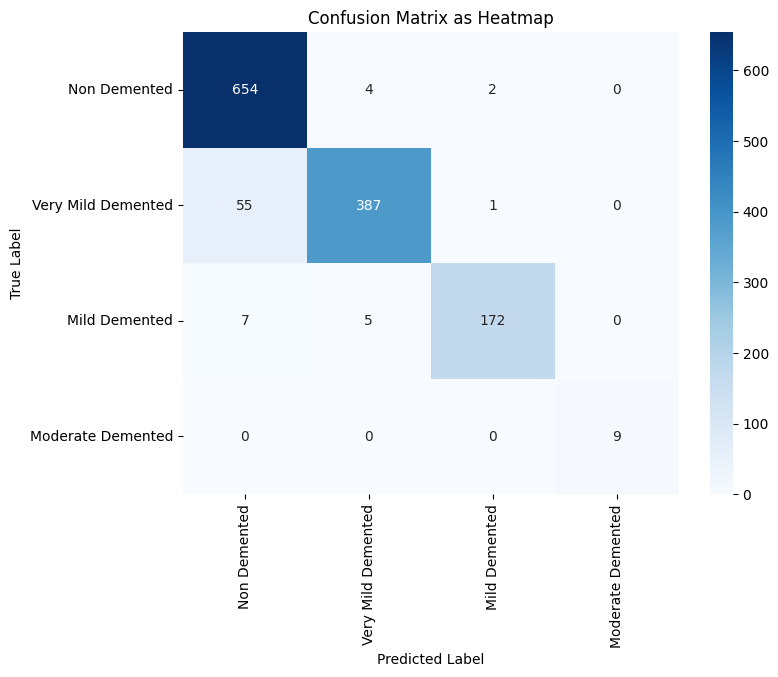

In [ ]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(208, 176, 3)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')  # Assuming 4 classes in the output
])

# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

evaluateModel(model=model, val_ds=val_ds, history=history)
print("Performance on Test data (previously unseen)")
evaluateModel(model=model, val_ds=test_ds, history=history)

Epoch 1/20
240/240 [==============================] - 6s 17ms/step - loss: 1.0207 - accuracy: 0.4797 - val_loss: 1.7698 - val_accuracy: 0.4842
Epoch 2/20
240/240 [==============================] - 4s 17ms/step - loss: 0.4522 - accuracy: 0.7552 - val_loss: 2.9611 - val_accuracy: 0.3592
Epoch 3/20
240/240 [==============================] - 4s 17ms/step - loss: 0.1677 - accuracy: 0.9232 - val_loss: 1.0646 - val_accuracy: 0.6329
Epoch 4/20
240/240 [==============================] - 4s 16ms/step - loss: 0.0712 - accuracy: 0.9711 - val_loss: 1.0117 - val_accuracy: 0.6954
Epoch 5/20
240/240 [==============================] - 4s 17ms/step - loss: 0.0474 - accuracy: 0.9854 - val_loss: 0.7980 - val_accuracy: 0.7318
Epoch 6/20
240/240 [==============================] - 4s 16ms/step - loss: 0.0366 - accuracy: 0.9862 - val_loss: 4.4960 - val_accuracy: 0.4763
Epoch 7/20
240/240 [==============================] - 4s 16ms/step - loss: 0.0335 - accuracy: 0.9885 - val_loss: 2.6998 - val_accuracy: 0.5419

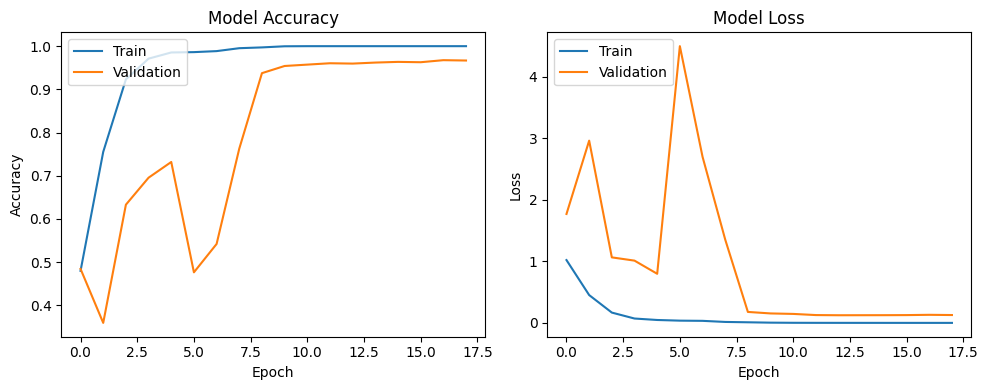

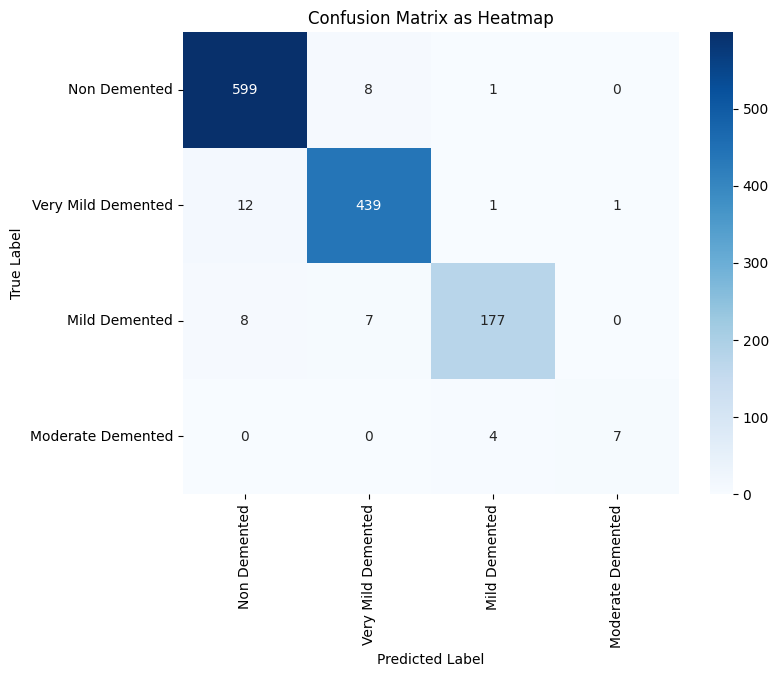

Performance on Test data (previously unseen)
Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.95      0.93      0.94       184
Very Mild Demented       1.00      1.00      1.00         9
     Mild Demented       0.98      0.98      0.98       660
 Moderate Demented       0.96      0.97      0.96       443

          accuracy                           0.97      1296
         macro avg       0.97      0.97      0.97      1296
      weighted avg       0.97      0.97      0.97      1296



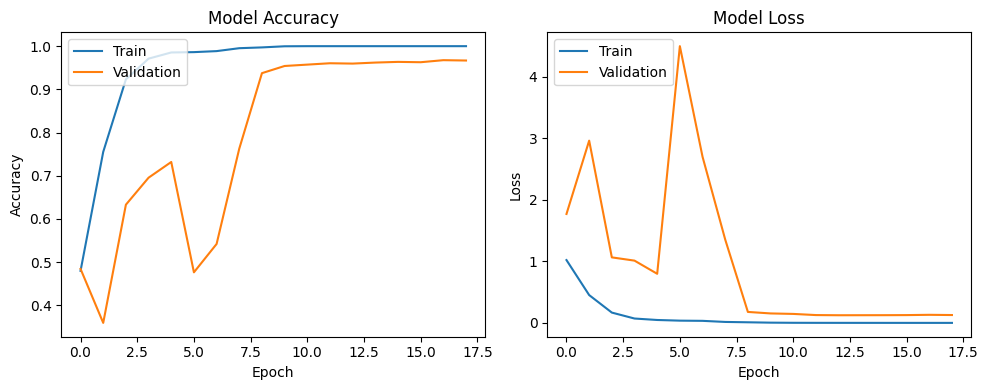

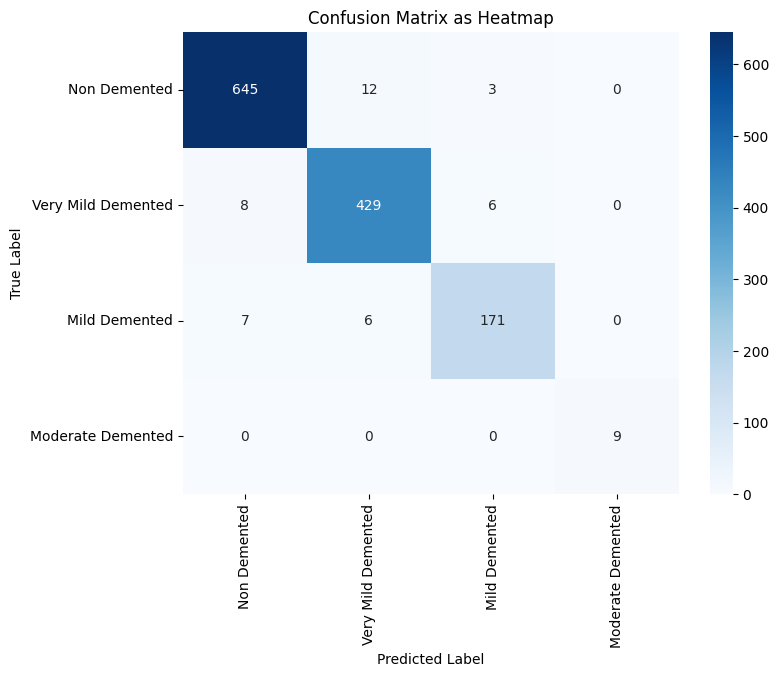

In [ ]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(208, 176, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')  # Assuming 4 classes in the output
])

# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping]
)


evaluateModel(model=model, val_ds=val_ds, history=history)
print("Performance on Test data (previously unseen)")
evaluateModel(model=model, val_ds=test_ds, history=history)


We tried changing the kernal size to 2 by 2 with padding and normalisation to see how it affects the accuracy.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 208, 176, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 208, 176, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 104, 88, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 104, 88, 64)    │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 104, 88, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 52, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 44, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 44, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73216)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,743,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,820,964 (71.80 MB)

 Trainable params: 18,819,748 (71.79 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 173s 692ms/step - accuracy: 0.4363 - loss: 1.2864 - val_accuracy: 0.0087 - val_loss: 2.4689
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 175s 730ms/step - accuracy: 0.8522 - loss: 0.2898 - val_accuracy: 0.5206 - val_loss: 1.8093
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 169s 704ms/step - accuracy: 0.9675 - loss: 0.0822 - val_accuracy: 0.7951 - val_loss: 0.6127
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 162s 677ms/step - accuracy: 0.9808 - loss: 0.0419 - val_accuracy: 0.9201 - val_loss: 0.2285
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 131s 544ms/step - accuracy: 0.9901 - loss: 0.0245 - val_accuracy: 0.1646 - val_loss: 6.2597
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 154s 643ms/step - accuracy: 0.9921 - loss: 0.0204 - val_accuracy: 0.8117 - val_loss: 0.6138
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 134s 560ms/step - accuracy: 0.9909 - loss: 0.0204 - val_accuracy: 0.9051 - val_loss: 0.3080
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 128s 533ms/step - accuracy: 0.9831 -

2024-05-17 16:47:32.922256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.32      1.00      0.49       192
Very Mild Demented       0.33      0.73      0.46        11
     Mild Demented       0.98      0.63      0.77       608
 Moderate Demented       0.94      0.53      0.68       453

          accuracy                           0.65      1264
         macro avg       0.65      0.72      0.60      1264
      weighted avg       0.86      0.65      0.69      1264



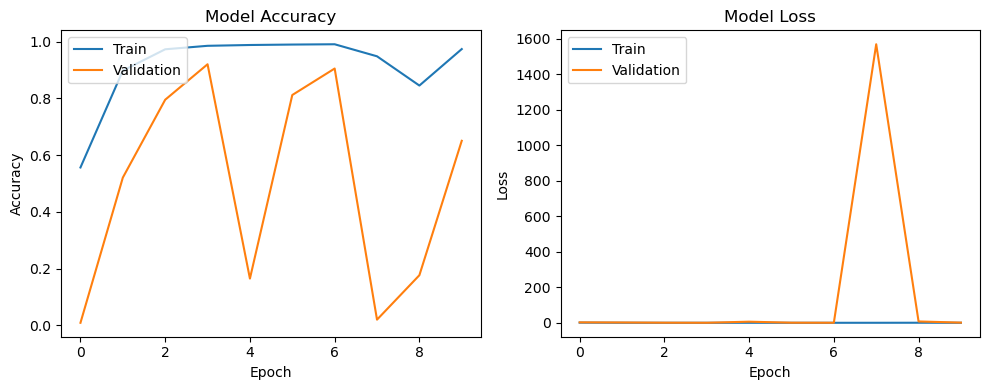

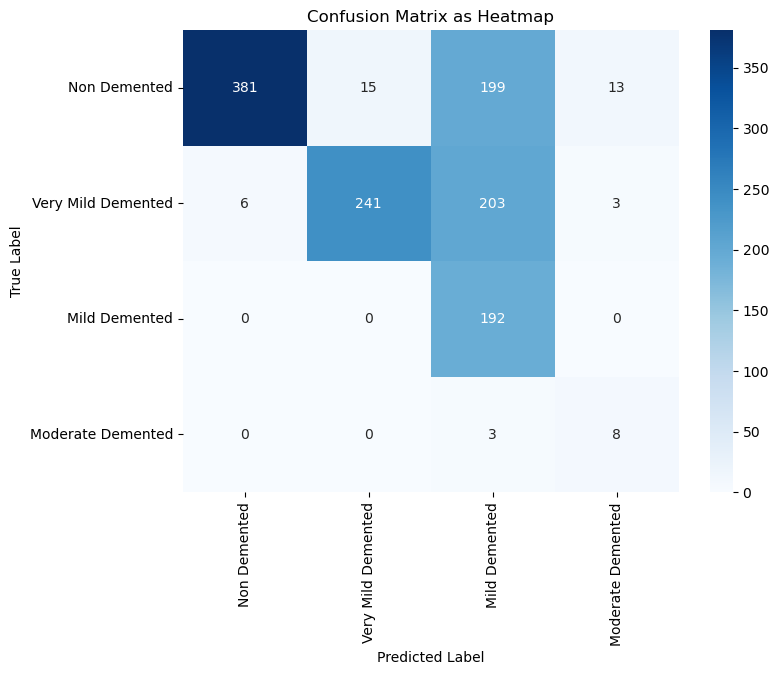

Performance on Test data (previously unseen)


2024-05-17 16:47:46.442840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.31      1.00      0.48       184
Very Mild Demented       0.35      1.00      0.51         9
     Mild Demented       0.97      0.63      0.77       660
 Moderate Demented       0.93      0.53      0.68       443

          accuracy                           0.65      1296
         macro avg       0.64      0.79      0.61      1296
      weighted avg       0.86      0.65      0.69      1296



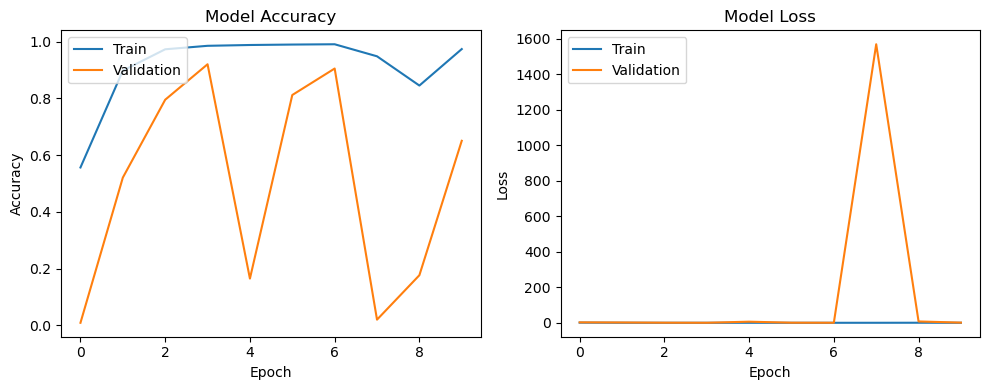

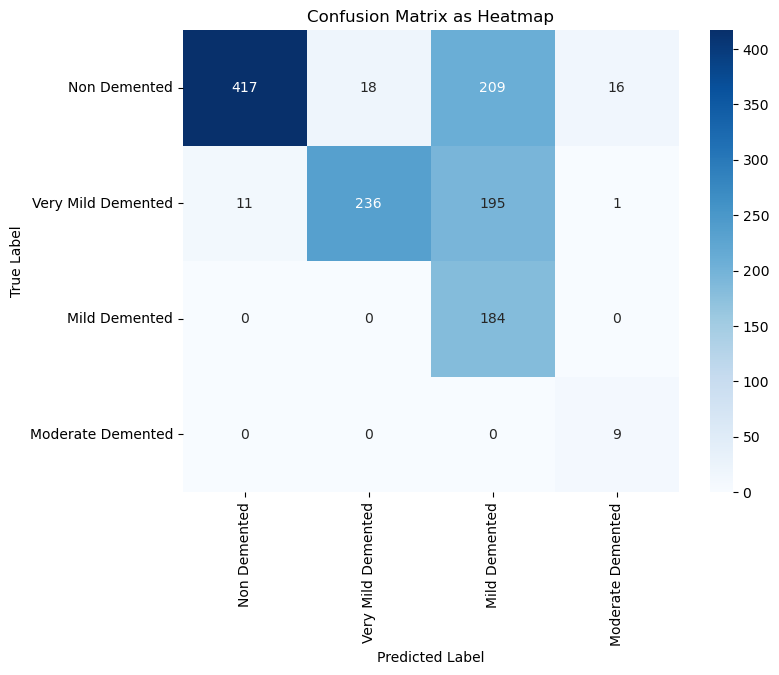

In [6]:

# Define the model architecture
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=(208, 176, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Second Convolutional Block
    layers.Conv2D(64, (2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Third Convolutional Block
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Flatten the output for the fully connected layers
    layers.Flatten(),

    # Dense Layers
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),


    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),


    # Output layer
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds, class_weight=class_weights)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


evaluateModel(model=model, val_ds=val_ds, history=history)
print("Performance on Test data (previously unseen)")
evaluateModel(model=model, val_ds=test_ds, history=history)


# Convolutional Neural Network using separableConv2D layer

We used Conv2d layers in all the above CNN's, now we tried using separableConv2d as its faster and much more memory efficient combined with Batch normalisation, Maxpooling,padding and dropouts. initially we used 4 Convolutions blocks to see how the accuracy changes as we remove the layers and dropouts as we did earlier

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 208, 176, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 208, 176, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 208, 176, 32)   │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 208, 176, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 104, 88, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 104, 88, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 104, 88, 64)    │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 104, 88, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 104, 88, 64)    │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 104, 88, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 52, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 52, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 26, 22, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 26, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 26, 22, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 26, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 13, 11, 256)    │        34,17

 Total params: 4,209,407 (16.06 MB)

 Trainable params: 4,205,951 (16.04 MB)

 Non-trainable params: 3,456 (13.50 KB)

Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.3181 - loss: 3.4510

2024-05-17 16:50:51.328840: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 7028800 bytes after encountering the first element of size 7028800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


240/240 ━━━━━━━━━━━━━━━━━━━━ 192s 775ms/step - accuracy: 0.3183 - loss: 3.4500 - val_accuracy: 0.4810 - val_loss: 4.4544 - learning_rate: 0.0010
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 187s 778ms/step - accuracy: 0.4688 - loss: 2.7193 - val_accuracy: 0.4810 - val_loss: 3.0196 - learning_rate: 0.0010
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 187s 777ms/step - accuracy: 0.5053 - loss: 2.4756 - val_accuracy: 0.4826 - val_loss: 2.9790 - learning_rate: 0.0010
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 783ms/step - accuracy: 0.5208 - loss: 2.3224 - val_accuracy: 0.4794 - val_loss: 3.1398 - learning_rate: 0.0010
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 165s 689ms/step - accuracy: 0.5492 - loss: 2.1573 - val_accuracy: 0.4905 - val_loss: 2.5432 - learning_rate: 0.0010
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 175s 729ms/step - accuracy: 0.5428 - loss: 2.0033 - val_accuracy: 0.4826 - val_loss: 2.1048 - learning_rate: 0.0010
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 161s 671ms/step - accuracy: 0.5625 

2024-05-17 17:17:10.143862: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 7028800 bytes after encountering the first element of size 7028800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


240/240 ━━━━━━━━━━━━━━━━━━━━ 187s 781ms/step - accuracy: 0.5908 - loss: 1.5711 - val_accuracy: 0.5847 - val_loss: 1.7003 - learning_rate: 0.0010
Epoch 11/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 165s 686ms/step - accuracy: 0.5926 - loss: 1.5154 - val_accuracy: 0.5941 - val_loss: 1.5211 - learning_rate: 0.0010
Epoch 12/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 164s 685ms/step - accuracy: 0.6105 - loss: 1.4562 - val_accuracy: 0.2682 - val_loss: 1.9300 - learning_rate: 0.0010
Epoch 13/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 170s 710ms/step - accuracy: 0.6122 - loss: 1.3991 - val_accuracy: 0.5609 - val_loss: 1.5535 - learning_rate: 0.0010
Epoch 14/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 162s 675ms/step - accuracy: 0.6260 - loss: 1.3427 - val_accuracy: 0.5229 - val_loss: 1.5727 - learning_rate: 2.0000e-04
Epoch 15/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 159s 663ms/step - accuracy: 0.6502 - loss: 1.2706 - val_accuracy: 0.5728 - val_loss: 1.4687 - learning_rate: 2.0000e-04
Epoch 16/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 158s 658ms/step - acc

2024-05-17 17:44:49.380370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.73      0.11      0.20       192
Very Mild Demented       0.86      0.55      0.67        11
     Mild Demented       0.60      0.92      0.73       608
 Moderate Demented       0.67      0.45      0.54       453

          accuracy                           0.62      1264
         macro avg       0.72      0.51      0.53      1264
      weighted avg       0.65      0.62      0.58      1264



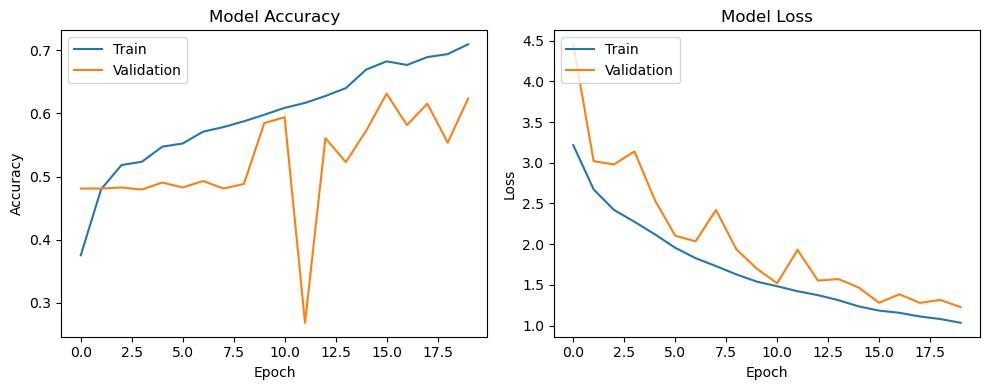

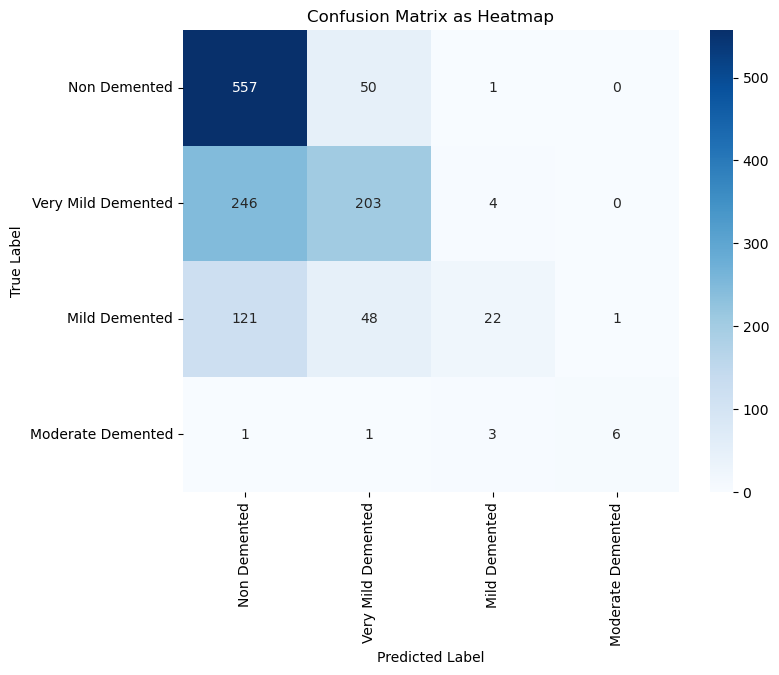

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

# Define the model architecture
model = models.Sequential([
    # First Convolutional Block
    layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same', input_shape=(208, 176, 3)),
    layers.BatchNormalization(),
    layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Second Convolutional Block
    layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Third Convolutional Block
    layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2)),
    layers.BatchNormalization(),
    layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Fourth Convolutional Block
    layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    # Flatten the output for the fully connected layers
    layers.Flatten(),

    # Dense Layers with L2 Regularization
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(len(class_names), activation='softmax')
])

# Implement learning rate scheduling
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Compile the model with custom optimizer and learning rate
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model with validation and learning rate scheduling
history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[reduce_lr])

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

evaluateModel(model = model, val_ds = val_ds, history = history)

Now, we remove one convolution block and use only one separableconv2d layer in each block unlike earlier to see if the performance improves.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_8              │ (None, 208, 176, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 208, 176, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 104, 88, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 104, 88, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_9              │ (None, 104, 88, 64)    │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 104, 88, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 52, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 52, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_10             │ (None, 52, 44, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 52, 44, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 26, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 26, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 73216)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    18,743,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,790,847 (71.68 MB)

 Trainable params: 18,789,631 (71.68 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 122s 480ms/step - accuracy: 0.3071 - loss: 1.9354 - val_accuracy: 0.3584 - val_loss: 34.3069
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 118s 492ms/step - accuracy: 0.3926 - loss: 1.3875 - val_accuracy: 0.3584 - val_loss: 60.8674
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 123s 512ms/step - accuracy: 0.4541 - loss: 1.0243 - val_accuracy: 0.3228 - val_loss: 34.8775
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 121s 505ms/step - accuracy: 0.4696 - loss: 1.0796 - val_accuracy: 0.5878 - val_loss: 1.0205
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 117s 486ms/step - accuracy: 0.5388 - loss: 0.8326 - val_accuracy: 0.5055 - val_loss: 1.1160
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 114s 474ms/step - accuracy: 0.5803 - loss: 0.7149 - val_accuracy: 0.5839 - val_loss: 1.0200
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 115s 480ms/step - accuracy: 0.6202 - loss: 0.6444 - val_accuracy: 0.5823 - val_loss: 2.0468
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 137s 571ms/step - accuracy: 0.638

2024-05-17 18:05:29.783761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:
                    precision    recall  f1-score   support

      Non Demented       1.00      0.10      0.19       192
Very Mild Demented       0.21      0.73      0.32        11
     Mild Demented       0.96      0.27      0.43       608
 Moderate Demented       0.42      0.96      0.58       453

          accuracy                           0.50      1264
         macro avg       0.65      0.52      0.38      1264
      weighted avg       0.77      0.50      0.45      1264



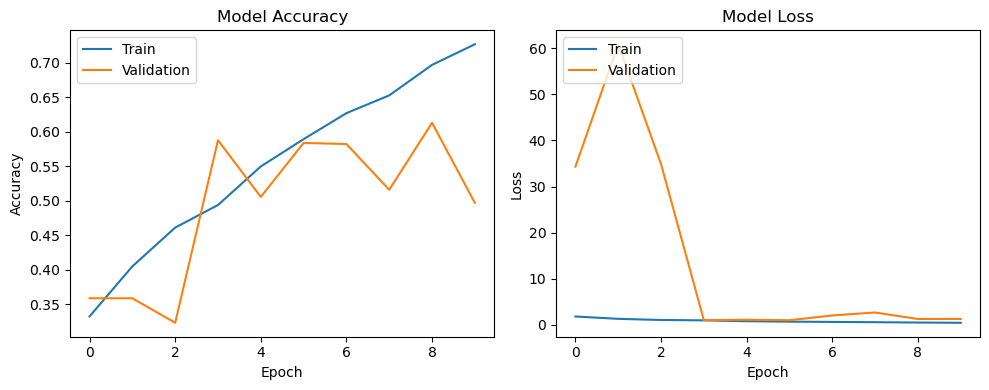

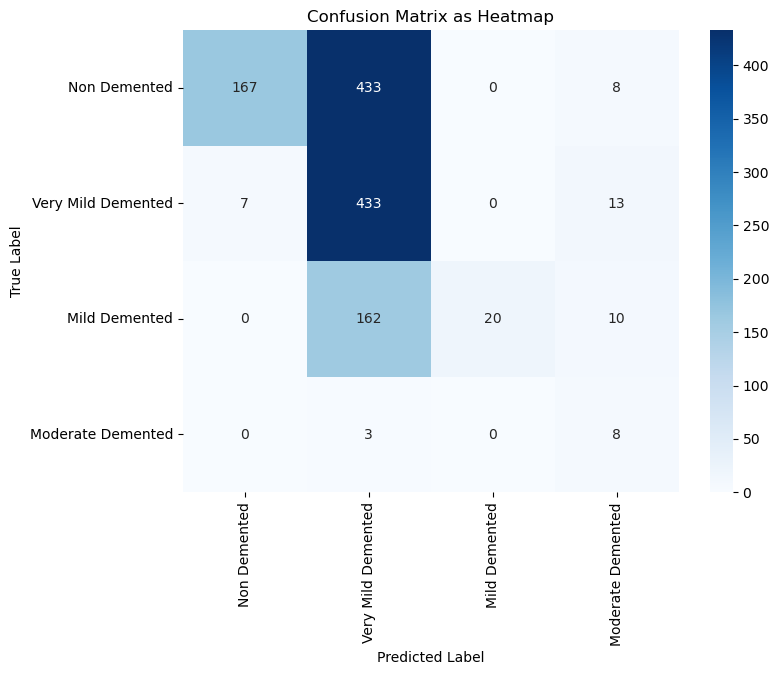

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model architecture
model = models.Sequential([
    # First Convolutional Block
    layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Block
    layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten the output for the fully connected layers
    layers.Flatten(),

    # Dense Layers
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds, class_weight=class_weights)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

evaluateModel(model = model, val_ds = val_ds, history = history)


Just like we did earlier, we removed the dropouts to check if the accuracy improves. also we changes the kernel size to 2 by 2 for a more detailed analysis of the scans.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_11             │ (None, 208, 176, 32)   │           140 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 208, 176, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 104, 88, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_12             │ (None, 104, 88, 64)    │         2,240 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 104, 88, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 52, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_13             │ (None, 52, 44, 128)    │         8,576 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 52, 44, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 73216)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │    18,743,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,790,352 (71.68 MB)

 Trainable params: 18,789,136 (71.67 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 134s 524ms/step - accuracy: 0.4291 - loss: 1.2172 - val_accuracy: 0.1519 - val_loss: 2.9727
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 111s 461ms/step - accuracy: 0.8417 - loss: 0.3004 - val_accuracy: 0.6788 - val_loss: 1.0333
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 120s 500ms/step - accuracy: 0.9681 - loss: 0.0749 - val_accuracy: 0.8331 - val_loss: 0.4471
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 121s 505ms/step - accuracy: 0.9940 - loss: 0.0241 - val_accuracy: 0.9035 - val_loss: 0.2654
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9912 - loss: 0.0244

2024-05-17 18:15:31.611524: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 7028800 bytes after encountering the first element of size 7028800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


240/240 ━━━━━━━━━━━━━━━━━━━━ 120s 499ms/step - accuracy: 0.9912 - loss: 0.0244 - val_accuracy: 0.9201 - val_loss: 0.2584
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 117s 487ms/step - accuracy: 0.9917 - loss: 0.0250 - val_accuracy: 0.8956 - val_loss: 0.3061
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 116s 486ms/step - accuracy: 0.9875 - loss: 0.0289 - val_accuracy: 0.8331 - val_loss: 0.5348
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 109s 455ms/step - accuracy: 0.9624 - loss: 0.0816 - val_accuracy: 0.7563 - val_loss: 0.8729
Epoch 9/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9725 - loss: 0.0651

2024-05-17 18:23:02.026382: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 7028800 bytes after encountering the first element of size 7028800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


240/240 ━━━━━━━━━━━━━━━━━━━━ 108s 449ms/step - accuracy: 0.9726 - loss: 0.0650 - val_accuracy: 0.9359 - val_loss: 0.2016
Epoch 10/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 113s 471ms/step - accuracy: 0.9871 - loss: 0.0262 - val_accuracy: 0.9264 - val_loss: 0.2726
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9127 - loss: 0.2654
Test Accuracy: 0.9128086566925049


2024-05-17 18:25:21.857600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.88      0.91      0.90       192
Very Mild Demented       1.00      0.73      0.84        11
     Mild Demented       0.99      0.90      0.94       608
 Moderate Demented       0.87      0.97      0.92       453

          accuracy                           0.93      1264
         macro avg       0.94      0.88      0.90      1264
      weighted avg       0.93      0.93      0.93      1264



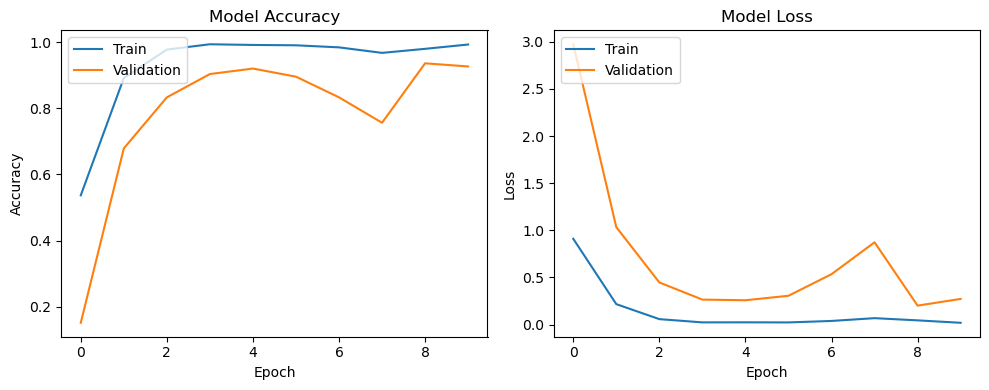

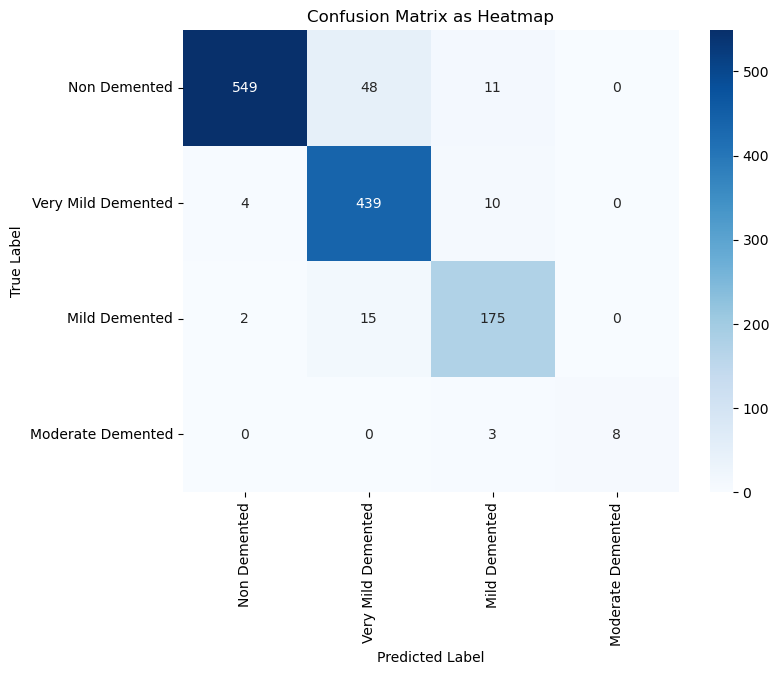

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model architecture
model = models.Sequential([
    # First Convolutional Block
    layers.SeparableConv2D(32, (2, 2), activation='relu', padding='same', input_shape=(208, 176, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Second Convolutional Block
    layers.SeparableConv2D(64, (2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Third Convolutional Block
    layers.SeparableConv2D(128, (2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Flatten the output for the fully connected layers
    layers.Flatten(),

    # Dense Layers
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),


    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),


    # Output layer
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds, class_weight=class_weights)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

evaluateModel(model = model, val_ds = val_ds, history = history)


We can see above the accuracy improves substantially than the model which used 4 convolutional blocks with separbleConv2d layers. We can see although these model are faster but separableConv2d models aren't not as good as Conv2d layers.

# Transfer Learning

In [ ]:


def load_model(model_name, input_shape):
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Model not supported")

    base_model.trainable = False
    return base_model

def add_custom_layers(base_model):
    model = tf.keras.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(64, activation='relu'),
        layers.Dense(4, activation='softmax')
    ])
    return model

def compile_and_train(model, train_ds, test_ds, epochs=10, BATCH_SIZE=None, class_weights=class_weights):

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=test_ds,
    verbose=1,
    epochs=epochs,
    class_weight=class_weights
    )
    return history

# Just For Mobilenet

In [ ]:

def load_model(model_name, input_shape):
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Model not supported")

    base_model.trainable = False
    return base_model

def add_custom_layers(base_model):
    model = tf.keras.Sequential([
        base_model,
        layers.Dropout(.5),
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(512,activation=tf.nn.relu),
        layers.BatchNormalization(),
        layers.Dropout(.5),
        layers.Dense(256,activation=tf.nn.relu),
        layers.BatchNormalization(),
        layers.Dropout(.5),
        layers.Dense(128,activation=tf.nn.relu),
        layers.BatchNormalization(),
        layers.Dropout(.5),
        layers.Dense(64,activation=tf.nn.relu),
        layers.BatchNormalization(),
        layers.Dropout(.5),
        layers.BatchNormalization(),
        layers.Dense(4, activation=tf.nn.softmax)
    ])
    return model

def compile_and_train(model, train_ds, test_ds, epochs=10, BATCH_SIZE=None, class_weights=class_weights):

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=test_ds,
    verbose=1,
    epochs=50,
    class_weight=class_weights
    )
    return history

# VGG2

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.2877 - loss: 2.9666 - val_accuracy: 0.3488 - val_loss: 1.4546
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.2902 - loss: 1.4509 - val_accuracy: 0.3519 - val_loss: 1.4358
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.4355 - loss: 1.2256 - val_accuracy: 0.2924 - val_loss: 1.6873
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.4478 - loss: 1.2398 - val_accuracy: 0.5471 - val_loss: 1.1739
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.5176 - loss: 1.0361 - val_accuracy: 0.5694 - val_loss: 1.1813
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.4923 - loss: 1.0592 - val_accuracy: 0.4776 - val_loss: 1.3268
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.5724 - loss: 0.9340 - val_accuracy: 0.5910 - val_loss: 1.1024
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.5387 - loss: 0.9278 - val_accu

2024-05-11 20:55:23.777973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.17      0.78      0.28       192
Very Mild Demented       0.03      0.64      0.06        11
     Mild Demented       0.56      0.05      0.10       608
 Moderate Demented       0.49      0.08      0.13       453

          accuracy                           0.18      1264
         macro avg       0.31      0.39      0.14      1264
      weighted avg       0.47      0.18      0.14      1264



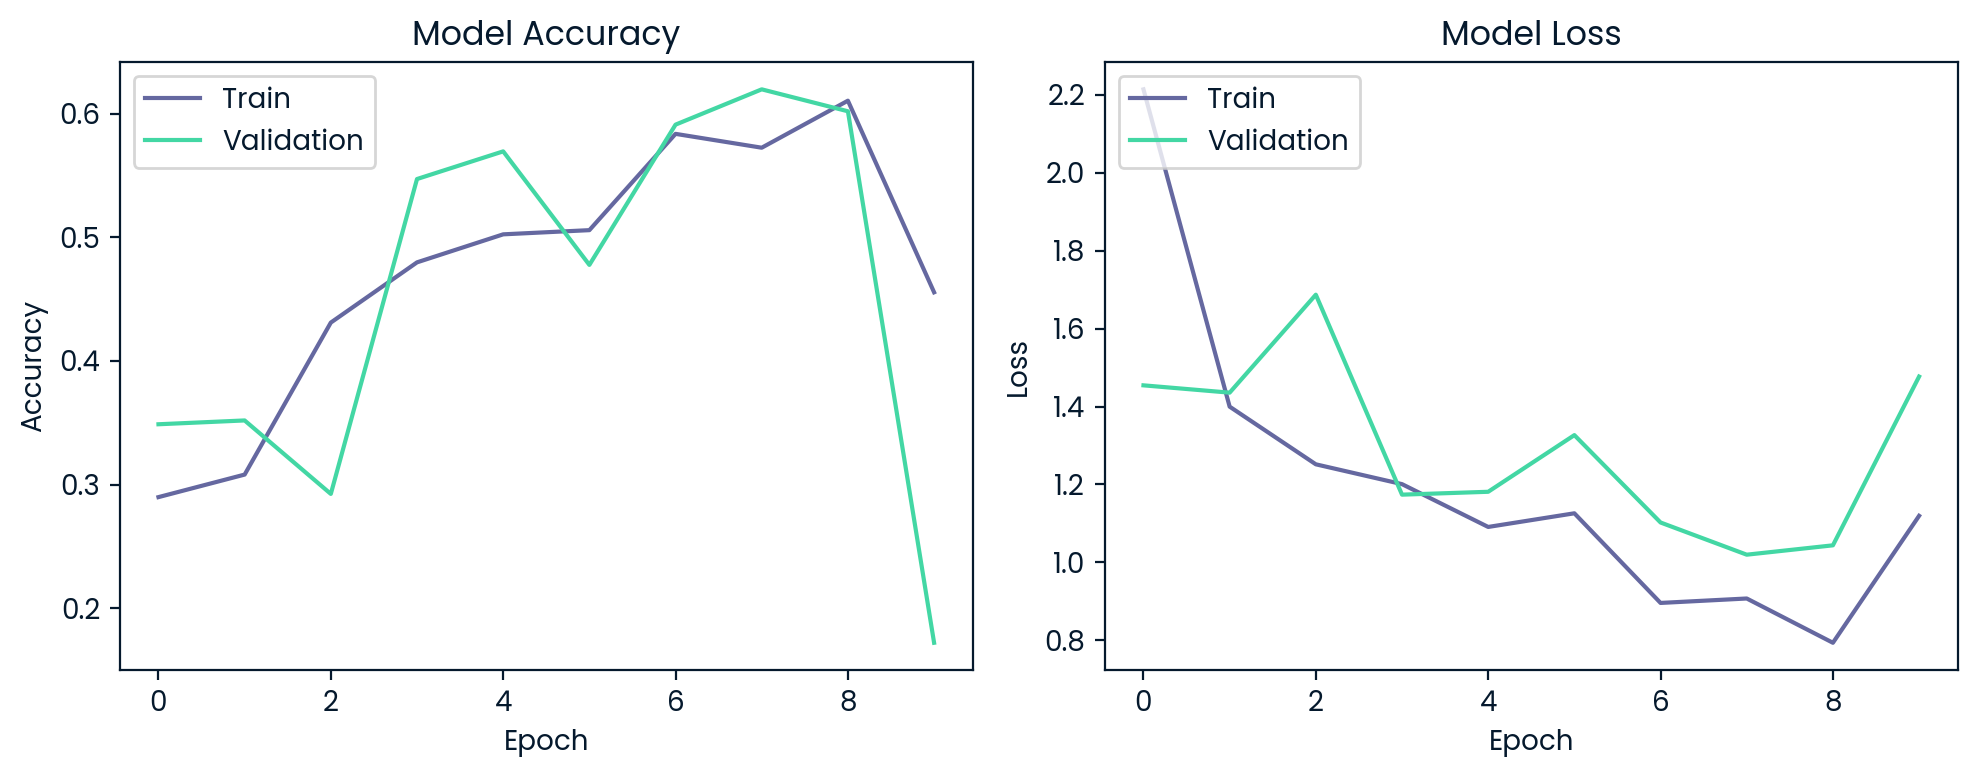

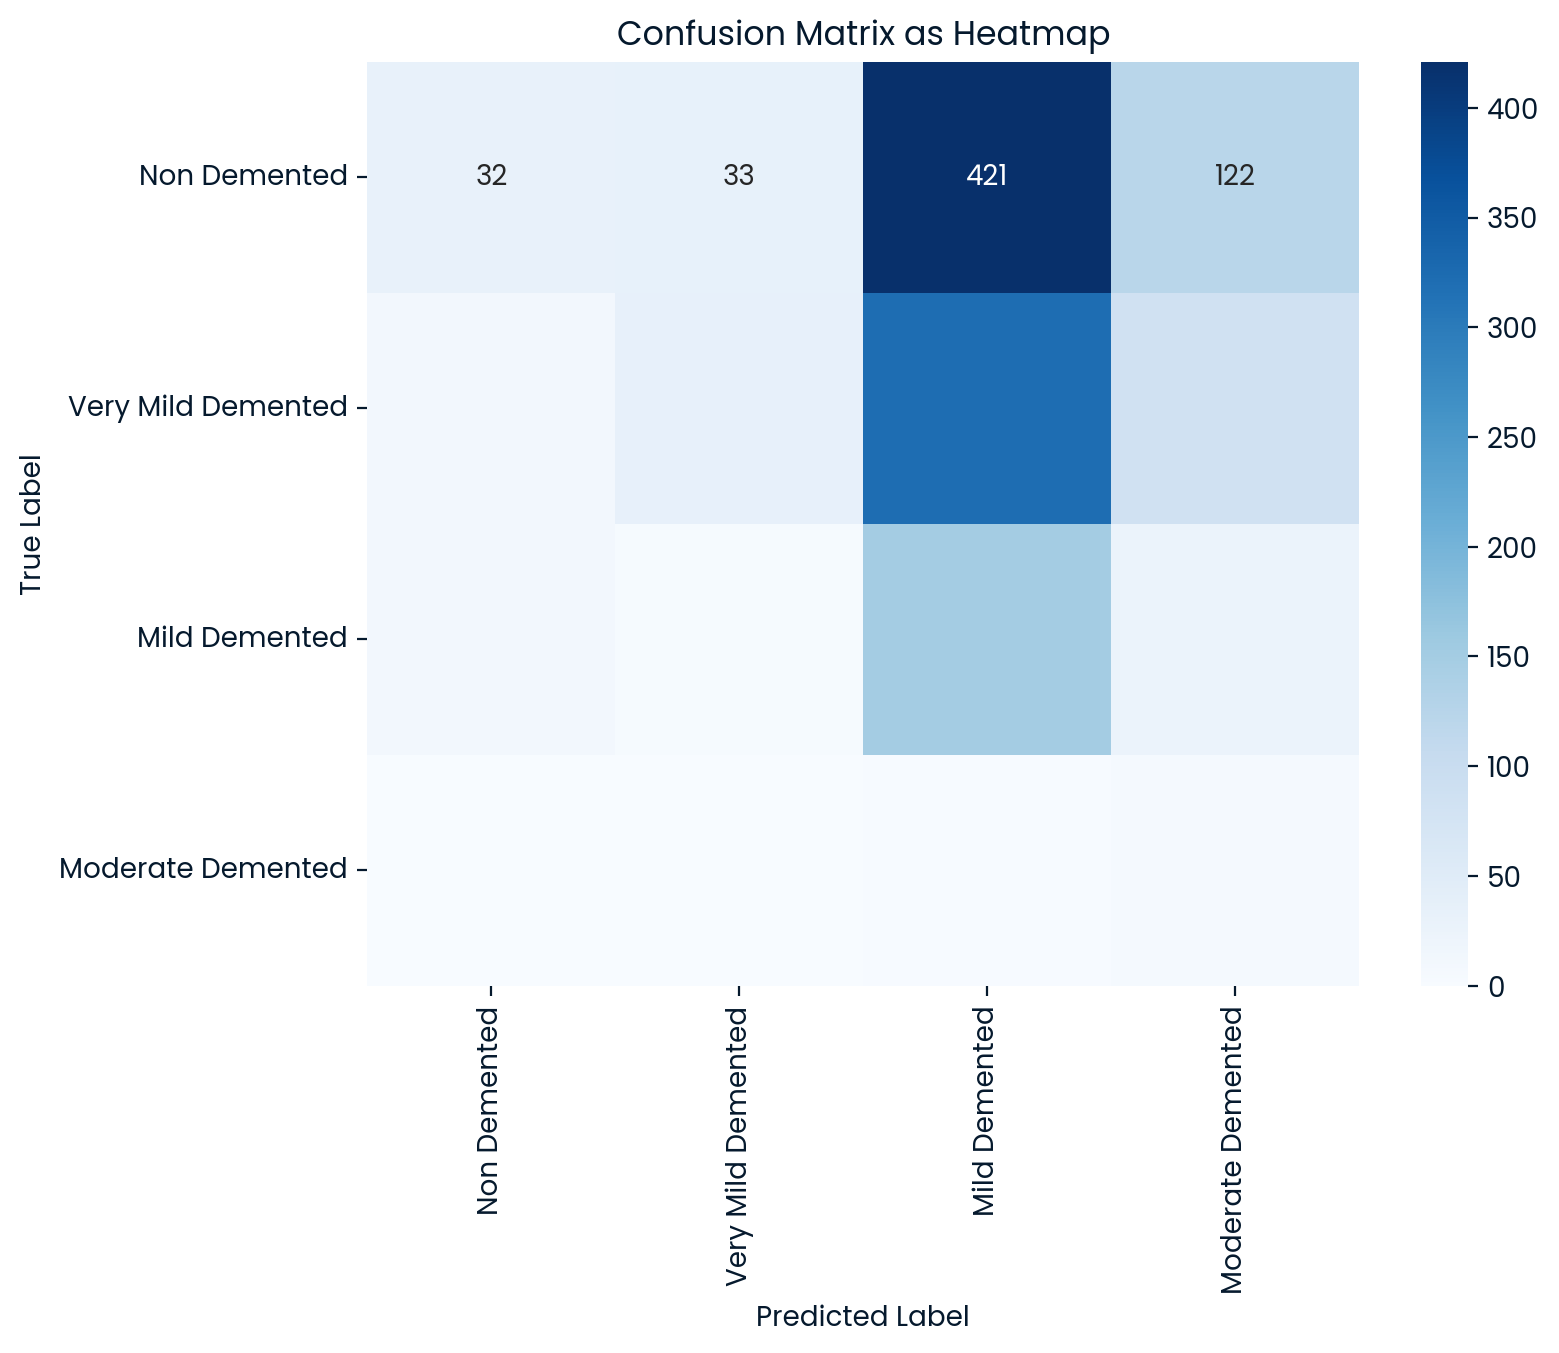

In [ ]:
# 1st model VGG16

model_name = 'VGG16'
base_model = load_model(model_name, input_shape)

model_VGG16 = add_custom_layers(base_model)
history_VGG16 = compile_and_train(model_VGG16, train_ds, test_ds, epochs=10)
test_loss, test_acc = model_VGG16.evaluate(train_ds)

evaluateModel(model = model_VGG16, val_ds = val_ds, history = history_VGG16)

In [ ]:
model_VGG16.save('model_VGG16.keras')

# InceptionV3

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 84s 324ms/step - accuracy: 0.3334 - loss: 22.2156 - val_accuracy: 0.4498 - val_loss: 3.7167
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 77s 321ms/step - accuracy: 0.4687 - loss: 3.2827 - val_accuracy: 0.5748 - val_loss: 1.9805
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 77s 319ms/step - accuracy: 0.5423 - loss: 1.7443 - val_accuracy: 0.5340 - val_loss: 1.6803
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 77s 321ms/step - accuracy: 0.5829 - loss: 1.2663 - val_accuracy: 0.6003 - val_loss: 1.2971
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 76s 316ms/step - accuracy: 0.4455 - loss: 1.5894 - val_accuracy: 0.4506 - val_loss: 1.4990
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 75s 313ms/step - accuracy: 0.4299 - loss: 1.3280 - val_accuracy: 0.4244 - val_loss: 1.4810
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 76s 318ms/step - accuracy: 0.4661 - loss: 1.2786 - val_accuracy: 0.1142 - val_loss: 3.0573
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 75s 313ms/step - accuracy: 0.4385 - loss: 

2024-05-11 21:09:22.659125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.44      0.60      0.51       192
Very Mild Demented       0.83      0.45      0.59        11
     Mild Demented       0.69      0.70      0.70       608
 Moderate Demented       0.53      0.44      0.48       453

          accuracy                           0.59      1264
         macro avg       0.62      0.55      0.57      1264
      weighted avg       0.59      0.59      0.59      1264



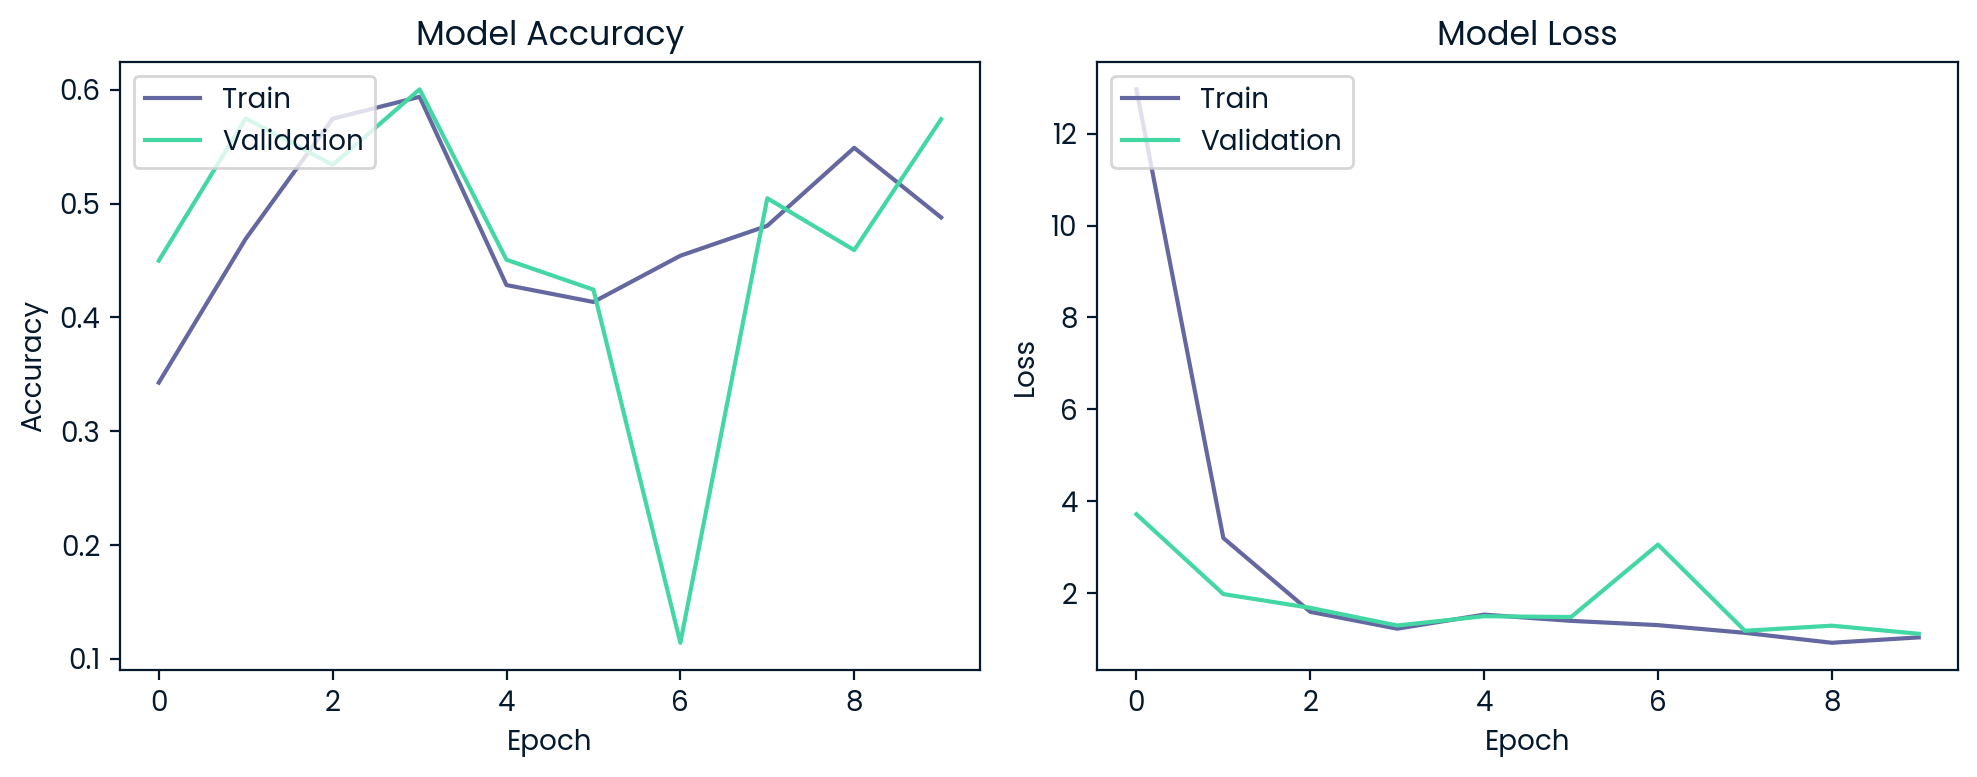

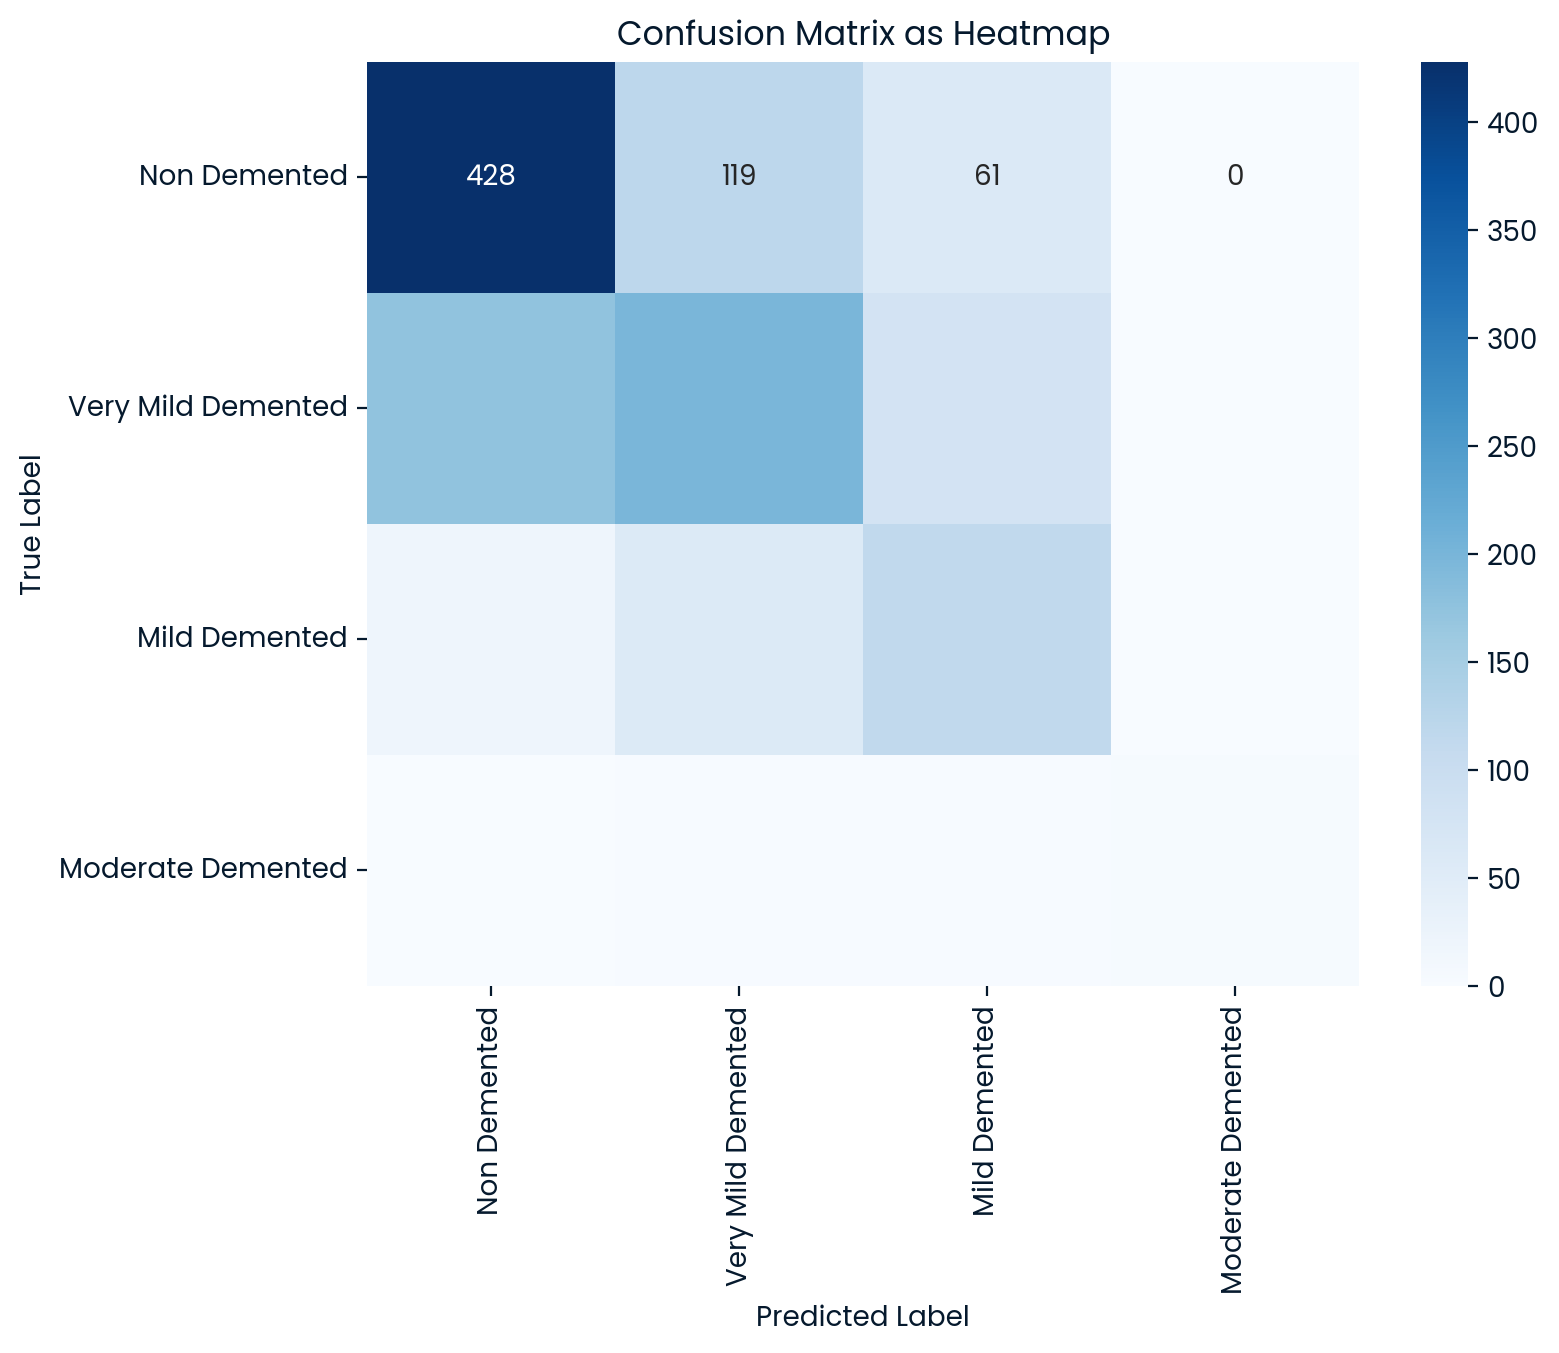

In [ ]:
# 2nd model InceptionV3

model_name = 'InceptionV3'
base_model = load_model(model_name, input_shape)

model_InceptionV3 = add_custom_layers(base_model)
history_InceptionV3 = compile_and_train(model_InceptionV3, train_ds, test_ds, epochs=10)
test_loss, test_acc = model_InceptionV3.evaluate(train_ds)

evaluateModel(model = model_InceptionV3, val_ds = val_ds, history = history_InceptionV3)

In [ ]:
model_InceptionV3.save('model_InceptionV3.keras')

# ResNet50

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 151s 602ms/step - accuracy: 0.2572 - loss: 8.4394 - val_accuracy: 0.5309 - val_loss: 1.4835
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 143s 597ms/step - accuracy: 0.3518 - loss: 1.7606 - val_accuracy: 0.4275 - val_loss: 1.4489
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 144s 600ms/step - accuracy: 0.3508 - loss: 1.6042 - val_accuracy: 0.3781 - val_loss: 1.4880
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 143s 598ms/step - accuracy: 0.3057 - loss: 1.4226 - val_accuracy: 0.1420 - val_loss: 1.4440
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 146s 607ms/step - accuracy: 0.2078 - loss: 1.4169 - val_accuracy: 0.1420 - val_loss: 1.4208
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 145s 606ms/step - accuracy: 0.2103 - loss: 1.3972 - val_accuracy: 0.1420 - val_loss: 1.4084
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 145s 604ms/step - accuracy: 0.2322 - loss: 1.3905 - val_accuracy: 0.1420 - val_loss: 1.4011
Epoch 8/10
240/240 ━━━━━━

2024-05-11 21:36:29.505730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.15      1.00      0.26       192
Very Mild Demented       0.00      0.00      0.00        11
     Mild Demented       0.00      0.00      0.00       608
 Moderate Demented       0.00      0.00      0.00       453

          accuracy                           0.15      1264
         macro avg       0.04      0.25      0.07      1264
      weighted avg       0.02      0.15      0.04      1264



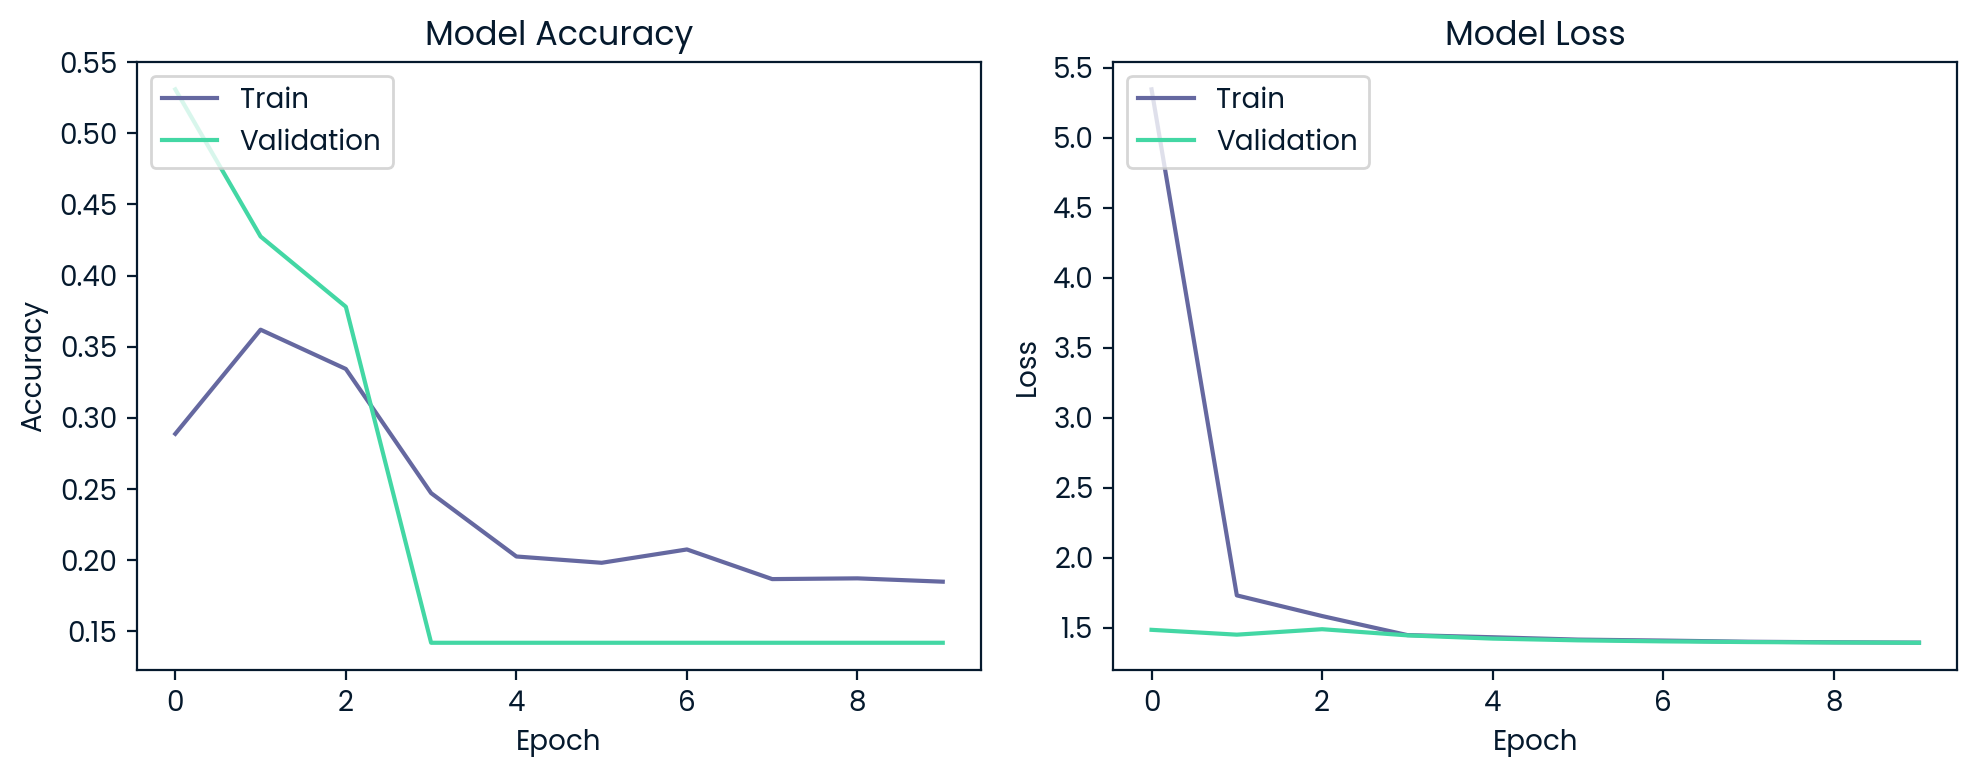

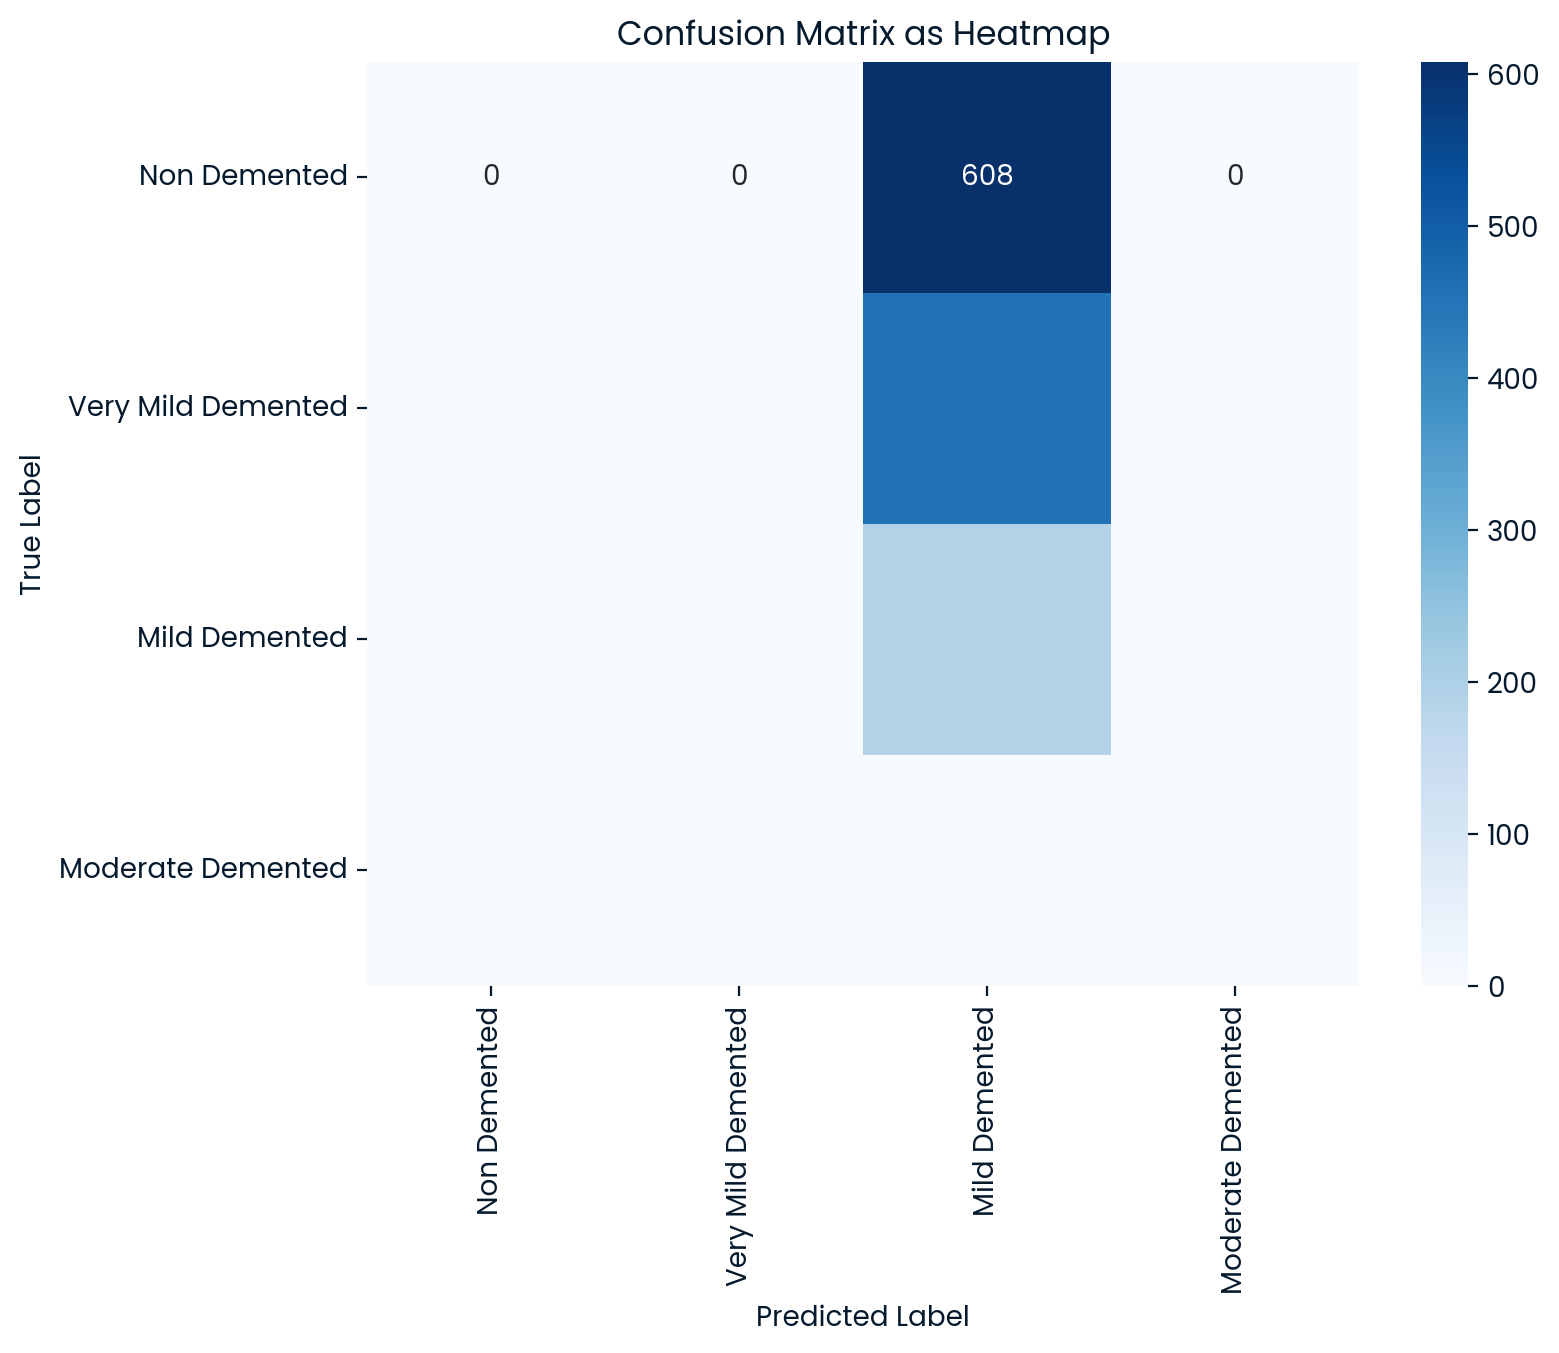

In [ ]:
# 3rd model ResNet50

model_name = 'ResNet50'
base_model = load_model(model_name, input_shape)

model_ResNet50 = add_custom_layers(base_model)
history_ResNet50 = compile_and_train(model_ResNet50, train_ds, test_ds, epochs=10)
test_loss, test_acc = model_ResNet50.evaluate(train_ds)

evaluateModel(model = model_ResNet50, val_ds = val_ds, history = history_ResNet50)

In [ ]:
model_ResNet50.save('model_ResNet50.keras')

# MobileNetV2

Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.2776 - loss: 1.7909 - val_accuracy: 0.4599 - val_loss: 1.1971
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 28s 117ms/step - accuracy: 0.2992 - loss: 1.4805 - val_accuracy: 0.4753 - val_loss: 1.1473
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 28s 117ms/step - accuracy: 0.3284 - loss: 1.3139 - val_accuracy: 0.4992 - val_loss: 1.1024
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.3650 - loss: 1.1948 - val_accuracy: 0.4830 - val_loss: 1.1365
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.3919 - loss: 1.0819 - val_accuracy: 0.5046 - val_loss: 1.0486
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step - accuracy: 0.4284 - loss: 0.9887 - val_accuracy: 0.5432 - val_loss: 1.0081
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.4575 - loss: 0.9247 - val_accuracy: 0.5378 - val_loss: 0.9924
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 28s 116ms/step - accuracy: 0.4745 - loss: 0

2024-05-12 17:11:27.642117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.73      0.77      0.75       192
Very Mild Demented       0.54      0.64      0.58        11
     Mild Demented       0.87      0.78      0.82       608
 Moderate Demented       0.73      0.81      0.77       453

          accuracy                           0.79      1264
         macro avg       0.72      0.75      0.73      1264
      weighted avg       0.80      0.79      0.79      1264



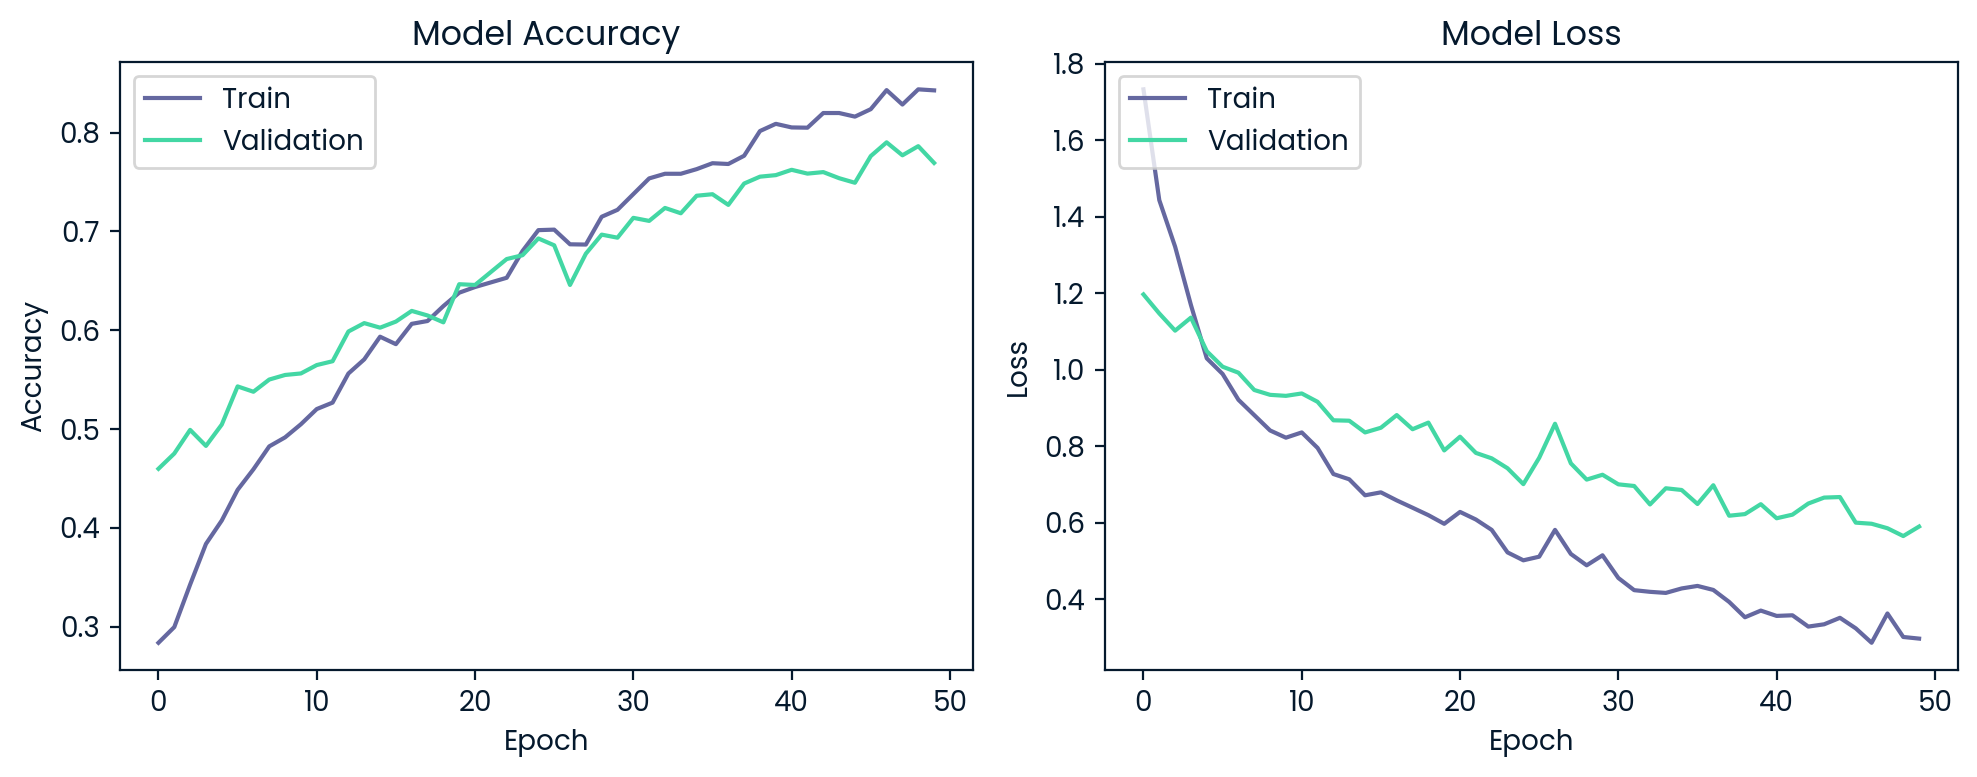

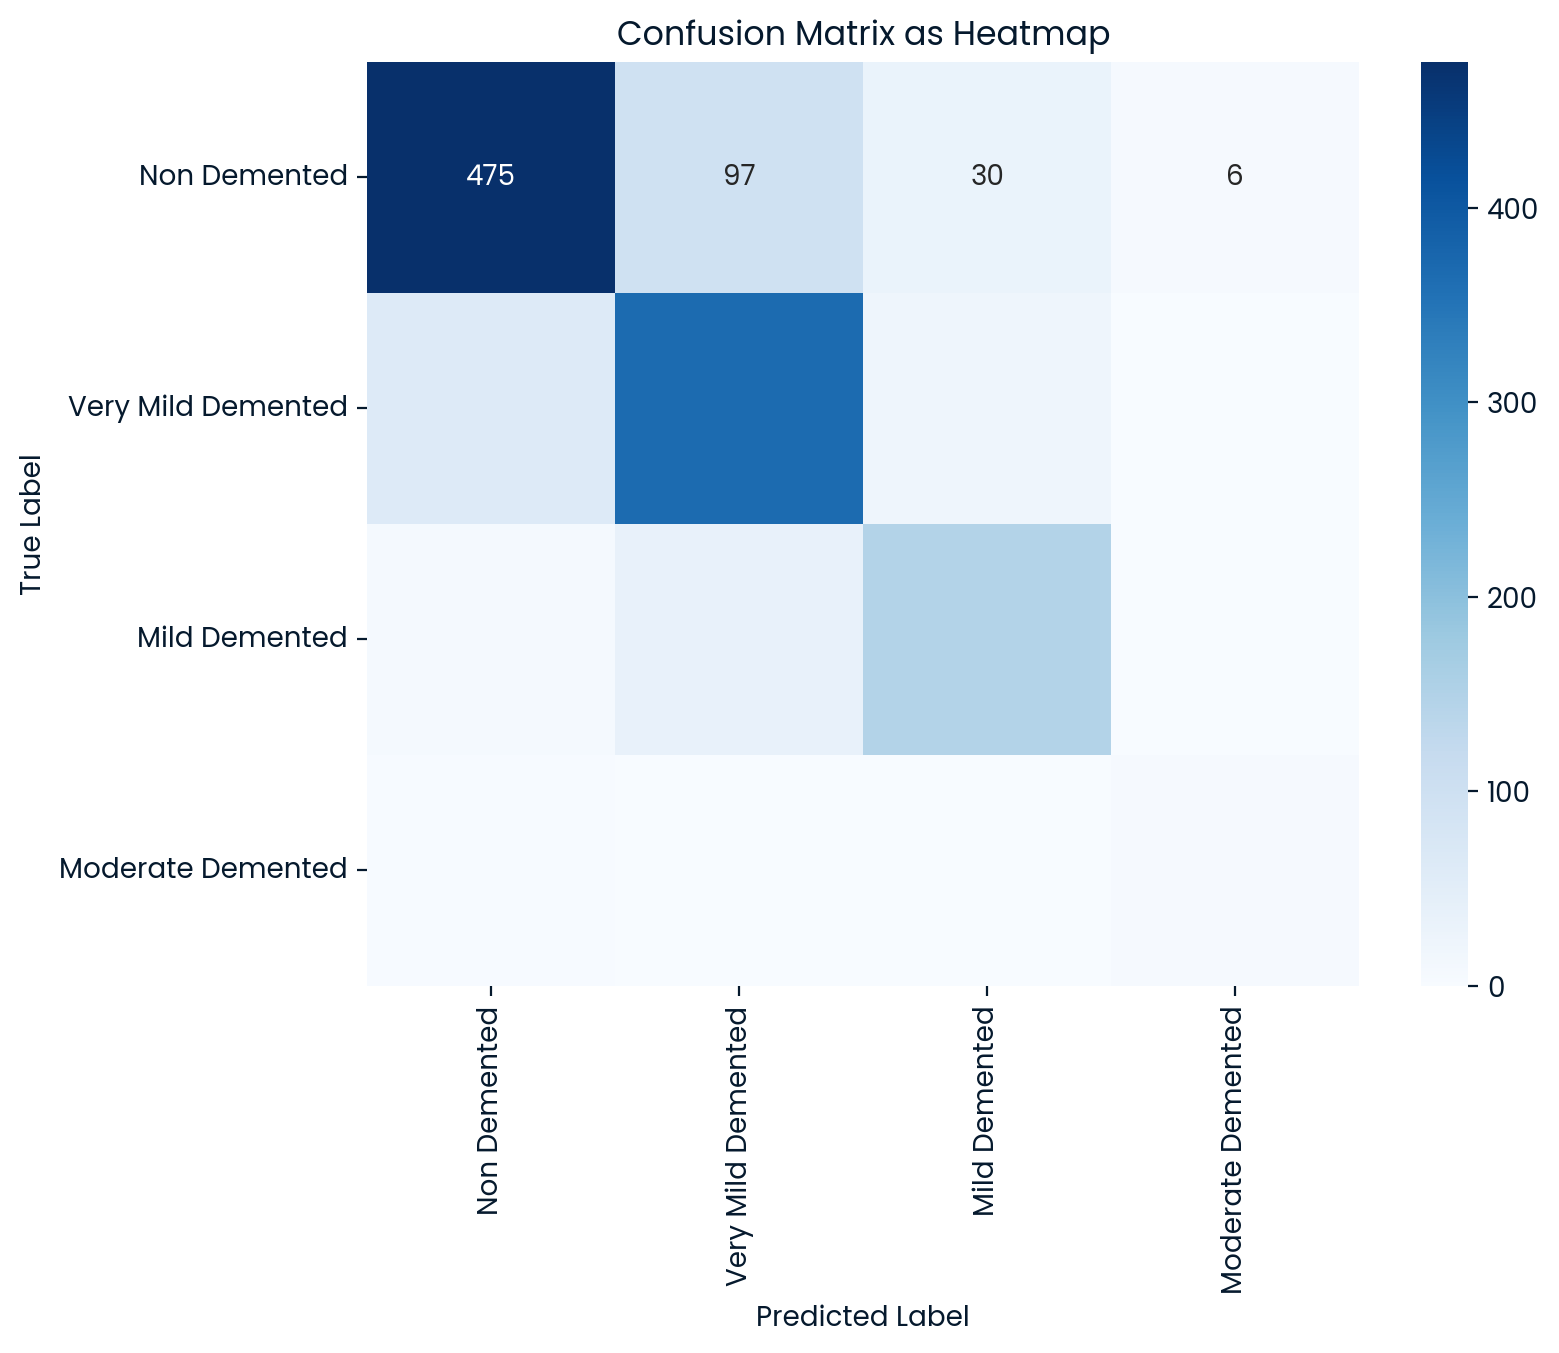

In [ ]:
# 4th model MobileNetV2

model_name = 'MobileNetV2'
base_model = load_model(model_name, input_shape)

model_MobileNetV2 = add_custom_layers(base_model)
history_MobileNetV2 = compile_and_train(model_MobileNetV2, train_ds, test_ds, epochs=10)
test_loss, test_acc = model_MobileNetV2.evaluate(train_ds)

evaluateModel(model = model_MobileNetV2, val_ds = val_ds, history = history_MobileNetV2)

In [ ]:
model_MobileNetV2.save('model_MobileNetV2_V3.keras')

# EfficientNetB0

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 83s 314ms/step - accuracy: 0.2751 - loss: 9.0303 - val_accuracy: 0.3418 - val_loss: 2.6793
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 74s 310ms/step - accuracy: 0.2403 - loss: 1.9598 - val_accuracy: 0.5093 - val_loss: 1.3001
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 75s 311ms/step - accuracy: 0.2386 - loss: 1.5532 - val_accuracy: 0.1420 - val_loss: 1.3789
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 75s 313ms/step - accuracy: 0.2528 - loss: 1.4108 - val_accuracy: 0.0069 - val_loss: 1.4187
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 74s 307ms/step - accuracy: 0.0723 - loss: 1.3919 - val_accuracy: 0.0069 - val_loss: 1.4028
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 74s 308ms/step - accuracy: 0.0127 - loss: 1.3760 - val_accuracy: 0.0069 - val_loss: 1.4037
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 73s 303ms/step - accuracy: 0.0446 - loss: 1.3757 - val_accuracy: 0.1420 - val_loss: 1.3935
Epoch 8/10
240/240 ━━━━━━━━━━━━━

2024-05-11 21:59:53.897866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:
                    precision    recall  f1-score   support

      Non Demented       0.15      1.00      0.26       192
Very Mild Demented       0.00      0.00      0.00        11
     Mild Demented       0.00      0.00      0.00       608
 Moderate Demented       0.00      0.00      0.00       453

          accuracy                           0.15      1264
         macro avg       0.04      0.25      0.07      1264
      weighted avg       0.02      0.15      0.04      1264



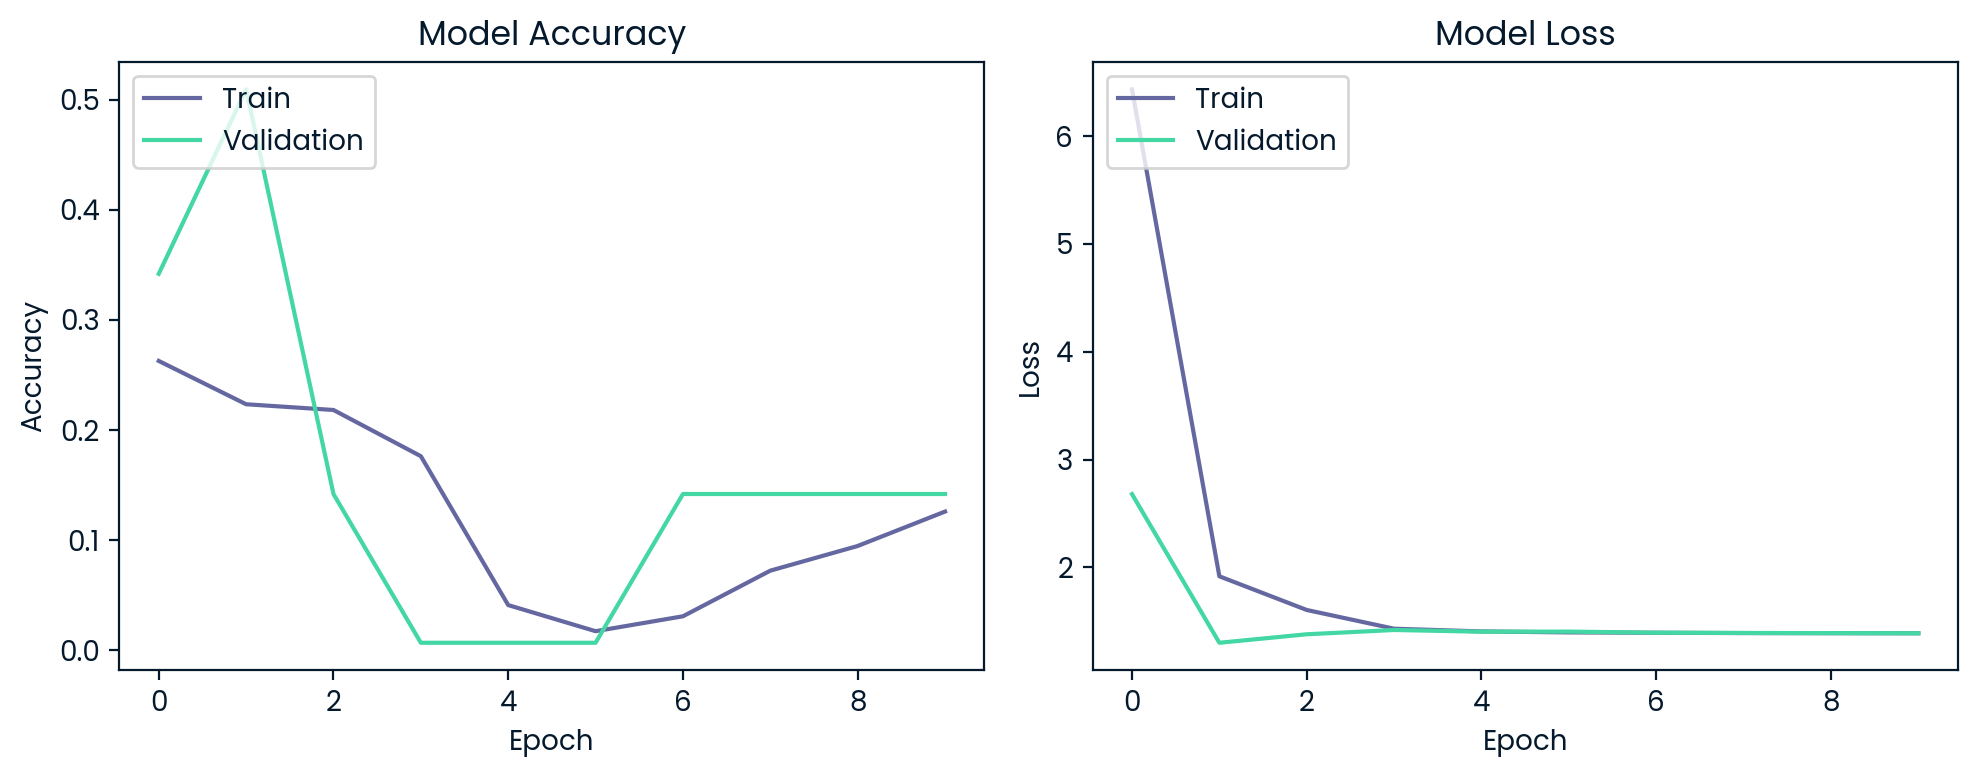

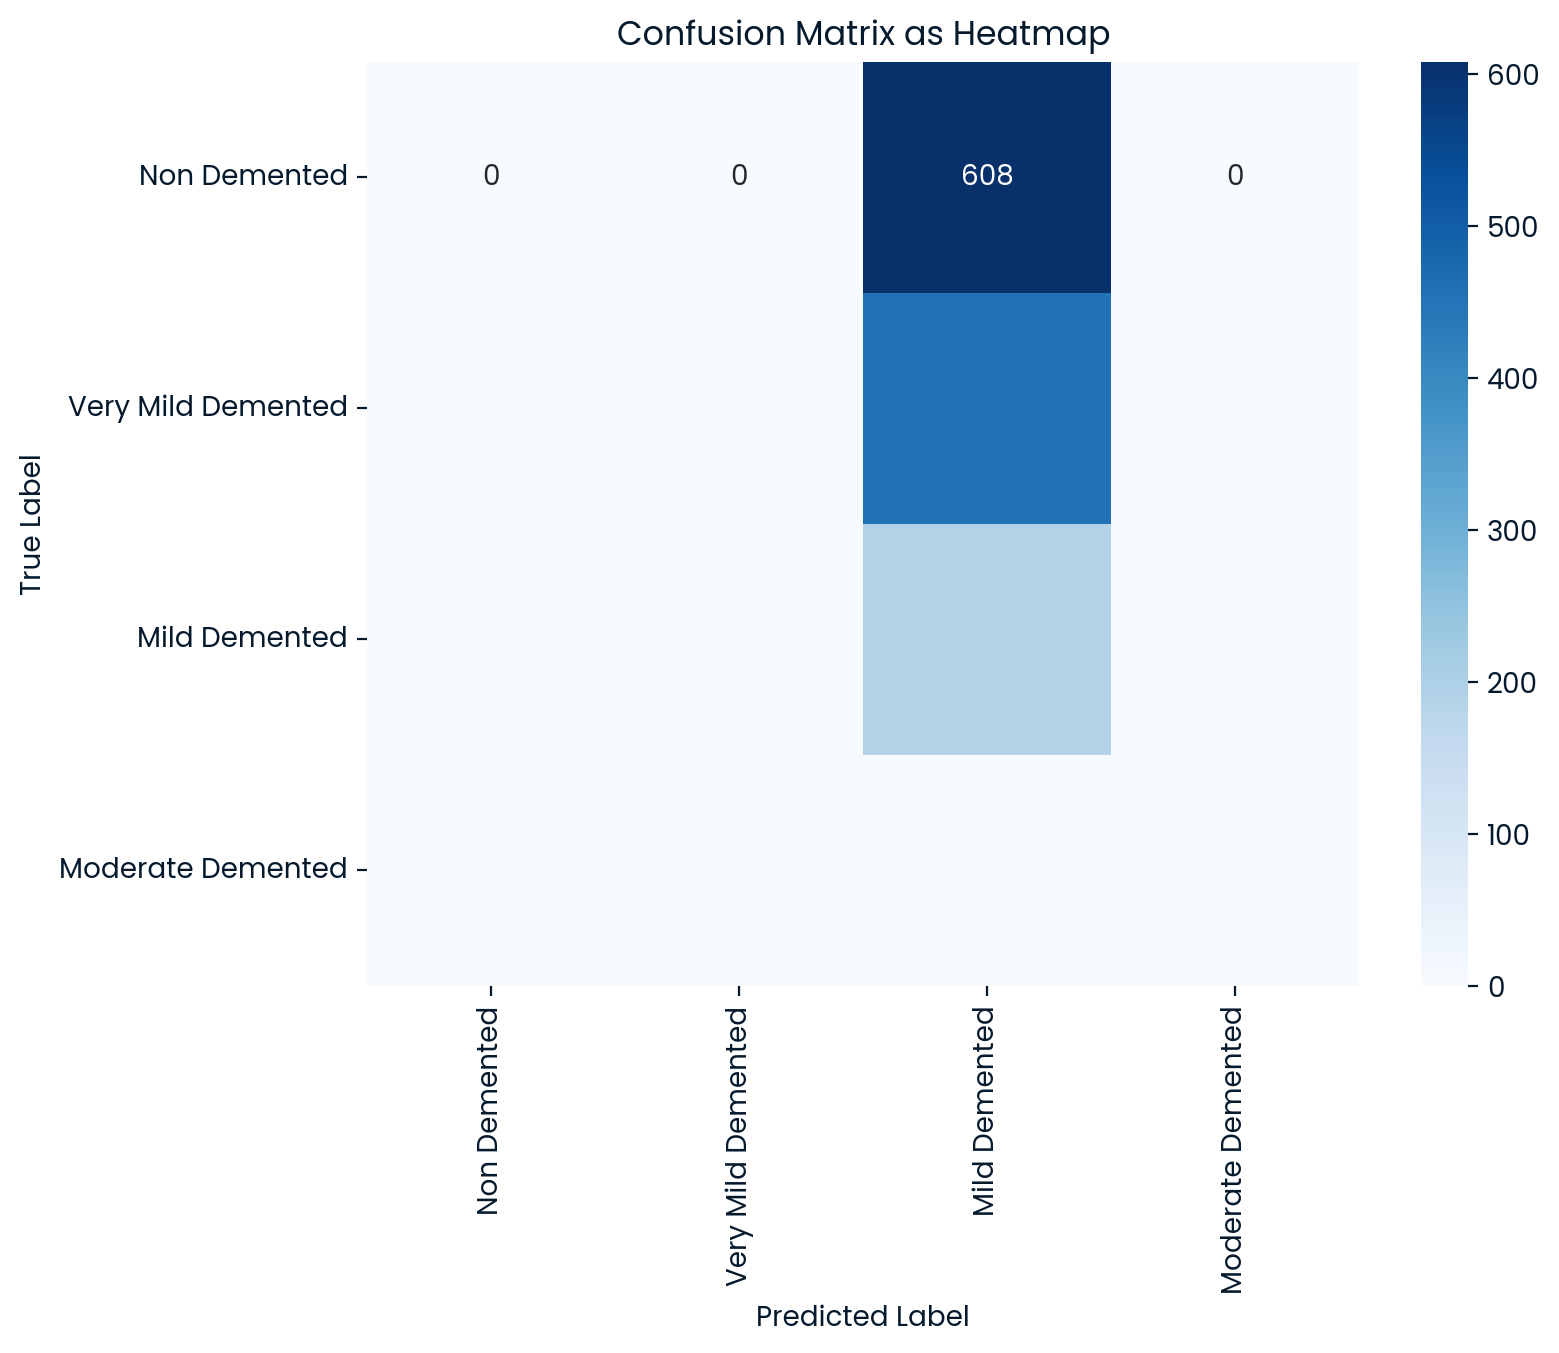

In [ ]:
# 5th model EfficientNetB0

model_name = 'EfficientNetB0'
base_model = load_model(model_name, input_shape)

model_EfficientNetB0 = add_custom_layers(base_model)
history_EfficientNetB0 = compile_and_train(model_EfficientNetB0, train_ds, test_ds, epochs=10)
test_loss, test_acc = model_EfficientNetB0.evaluate(train_ds)

evaluateModel(model = model_EfficientNetB0, val_ds = val_ds, history = history_EfficientNetB0)